# Project: March Data Crunch Madness Competition

### **Objective:** As part of the Deloitte-sponsored March Data Crunch Madness Competition, I was tasked with predicting the probability of each outcome of the 2019 NCAA Men's March Madness tournament bracket. I was evaluated on log loss.

### **Summary:** 
- **Data Pre-Processing:** I used extensive data pre-processing to get the data ready for modeling.
    - The data was originally provided in a state where the *team1* variable was always defined as the winning team, which would make the outcome variable 1 for each data point. To turn this into a classifiction problem, I randomly swapped the team 1 and team 2 information for half of the data points to create a balanced binary outcome variable.
    - I found missing values in features that contained coach AP poll rankings. With further research, I found that values were only provided if the coach was in the top 25 for a given year. Knowing that these features were ordinal, but rakings were unknown, I filled missing values with a rank of 26 to indicate that the coaches had a lower rank than those who are ranked 5 and that they are equally ranked.
    - I corrected data types so they'd be interpretted correctly by classification models.
    - I converted all categorical features to dummies to provide models with only quantiative features.
- **Merging External datasets/Creating new features:** I used external research to create features and joim additional datasets with the given dataset.
    - I used location data to derive the distance that a team had to travel from their hometown to specific matchup schools.
    - I derived a feature to determine if a school made it to the final four round last year or within the last 3 years.
    - I used my external research to add additional school stats, school conference and conference stats, as well as player stats.
- **Feature engineering**
    - I normalized all features as I knew some classification techniques are sensitive to the scale of certain features, and my feature scales vary widely (i.e. 3-point % vs distance from hometown (m))
- **Train/test split**
    - I used this step to figure out the best subset of data to use since domain knowledge would prove that the last 17 years of data would not be a good predictor of the current year's matchups as outcomes/teams change after periods of time. With testing, I found that the last 5 years of data worked best, so I only used the last 5 years of data (2013-2017) to test on the most recent year of complete data (2018).
- **Feature Selection**
    - I used L1 regularized linear regression (lasso) to arrive at the best set of features. I narrowed the amount of total features from 228 to 25.
- **Modeling and evaluation**
    - I selected various classification models: Logistic regression, SVM, Random Forest, K-Nearest Neighbors, and an ensemble of all models. I used log loss to evaluate each one on the 2018 dataset. SVM performed best with a log loss of 0.53 and an accuracy of 73%.
- **Results**
    - The SVM model provided consistent results on 2019 data with a log loss of 0.51 andaccuracy of 75%.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns; sns.set()
import warnings
import statistics 

warnings.simplefilter('ignore')


#Model Packages
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier  

 #Feature Selection Packages
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold

C:\Users\janel\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data

The data provided includes 17 year of NCAA Men's March Madness tournament matchups. Each instance contains features like each team's stats, coach information, and rankings.

In [2]:
data = pd.read_csv("NCAA_Tourney_2002_2018.csv")
pd.options.display.max_columns = None  # Displays all columns in df
pd.options.display.max_rows = None  # Displays all rows in df

In [3]:
data.head()

,team1_id,team1_score,team2_id,team2_score,WLoc,num_ot,team1_position,team2_position,team1_seed,team2_seed,strongseed,weakseed,team1_region,team2_region,slot,team1_teamname,team2_teamname,season,host,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,game_id
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W,W,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108
1,1104,86,1194,78,N,0,Y02,Y15,2,15,2,15,Y,Y,R1Y2,Alabama,FL Atlantic,2002,greenville,35.6017,-77.3725,33.214400,-87.545766,26.372536,-80.102293,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,8.0,24.0,8.0,NaN,NaN,NaN,NaN,NaN,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,2002-1104-1194
2,1112,86,1364,81,N,0,Z03,Z14,3,14,3,14,Z,Z,R1Z3,Arizona,Santa Barbara,2002,albuquerque,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,lute-olson-1,17.0,22.0,8.0,10.0,4.0,5.0,467.0,144,656.0,239,22.0,9,22.0,9,bob-williams-1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,52,62.0,52,20.0,10,20.0,10,7.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185,43.1723,32.0968,69.3679,6.7061,32.3549,39.4402,65.7778,58.5246,0.0868,0.0778,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,2002-1112-1364
3,1181,84,1457,37,N,0,Y01,Y16,1,16,1,16,Y,Y,R1Y1,Duke,Winthrop,2002,greenville,35.6017,-77.3725,36.001590,-78.942260,34.938510,-81.028663,mike-krzyzewski-1,17.0,17.0,12.0,12.0,9.0,9.0,562.0,167,635.0,226,29.0,3,29.0,3,gregg-marshall-1,3.0,3.0,0.0,0.0,0.0,0.0,79.0,41,79.0,41,19.0,11,19.0,11,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,

In [4]:
data.shape

(1112, 104)

# Data Summary

In [5]:
data.describe()

,team1_id,team1_score,team2_id,team2_score,num_ot,team1_seed,team2_seed,strongseed,weakseed,season,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde
count,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,759.000000,651.000000,764.000000,613.000000,403.000000,342.000000,383.000000,324.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000
mean,1294.275180,75.408273,1294.783273,64.000000,0.071043,5.151079,8.813849,3.920863,10.044065,2010.097122,38.069318,-92.201793,38.141361,-88.920553,37.942730,-90.094100,5.545863,8.681655,2.882194,4.178058,1.063849,1.466727,209.513489,84.362410,346.713129,153.535072,27.510791,7.635791,25.118705,7.123201,3.262590,5.383094,1.401079,2.116007,0.477518,0.674460,153.866906,78.747302,252.680755,135.425360,25.779676,8.891187,23.428058,8.593525,10.011858,9.840246,9.740838,9.652529,13.173697,12.581871,13.336815,12.490741,51.295981,36.426244,70.907142,11.124787,45.148329,32.799256,69.070052,8.365315,32.993649,33.060414,55.915376,51.716273,0.103637,0.088147,50.550596,35.988968,70.634399,10.239078,46.013540,33.229407,69.211347,8.530778,33.442078,33.282912,55.730459,52.134852,0.101370,0.090135,67.641909,67.319748,110.987460,112.914521,95.363060,93.965913,67.435028,67.154363,108.633711,109.629406,96.992843,96.413722
std,101.620939,10.715982,106.398732,10.417133,0.302089,3.992863,4.626117,3.114242,3.949141,4.903526,4.719764,14.532305,4.158697,12.983528,4.353578,13.886183,6.696834,7.634619,4.304726,4.938209,2.162704,2.494056,196.170639,65.609371,237.159495,92.383396,34.184782,7.193700,3.854735,3.086821,5.015487,6.295799,3.098026,3.712197,1.508881,1.746838,148.078865,61.366468,199.142495,89.680159,38.319010,5.5

In [6]:
# plt.plot(data["team1_teamname"],)
# plt.show()

# Data Cleaning

### Randomizing team1 and team2

In [7]:
####Random sample of half of the data (556 rows)
random_sample_swap = data.sample(n=round(len(data)/2),random_state=1)
random_sample_swap.index

Int64Index([ 306,  707,  126,  691,  874,  226,  741,  868,  200,  133,
            ...
             678,  466,  953,  447,  371, 1003,  449,  886,  523,  214],
           dtype='int64', length=556)

In [8]:
####Randomize the team IDs

#Use the random sample and change "team1" to "team2new"

data_to_swap = data.iloc[random_sample_swap.index]
data_to_swap.columns = data_to_swap.columns.str.replace("team1", "team3temp")
data_to_swap.head()
data_to_swap.columns = data_to_swap.columns.str.replace("team2", "team1")
data_to_swap.head()
data_to_swap.columns = data_to_swap.columns.str.replace("team3temp", "team2")
data_to_swap.sort_index().head()

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,team2_region,team1_region,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W,W,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108
2,1112,86,1364,81,N,0,Z03,Z14,3,14,3,14,Z,Z,R1Z3,Arizona,Santa Barbara,2002,albuquerque,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,lute-olson-1,17.0,22.0,8.0,10.0,4.0,5.0,467.0,144,656.0,239,22.0,9,22.0,9,bob-williams-1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,52,62.0,52,20.0,10,20.0,10,7.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185,43.1723,32.0968,69.3679,6.7061,32.3549,39.4402,65.7778,58.5246,0.0868,0.0778,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,2002-1112-1364
3,1181,84,1457,37,N,0,Y01,Y16,1,16,1,16,Y,Y,R1Y1,Duke,Winthrop,2002,greenville,35.6017,-77.3725,36.001590,-78.942260,34.938510,-81.028663,mike-krzyzewski-1,17.0,17.0,12.0,12.0,9.0,9.0,562.0,167,635.0,226,29.0,3,29.0,3,gregg-marshall-1,3.0,3.0,0.0,0.0,0.0,0.0,79.0,41,79.0,41,19.0,11,19.0,11,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,57.4329,36.2651,68.9845,7.2251,46.2916,30.2703,68.8693,7.4692,37.5736,26.1916,57.1821,49.5516,0.1297,0.0919,47.6420,30.5603,65.5914,11.6301,45.6625,30.4104,68.8372,9.8171,36.1794,33.8170,49.0370,51.8692,0.1108,0.0987,77.0734,75.1685,116.3726,118.5999,90.2544,87.7504,68.2128,67.4639,100.2384,95.3632,94.6587,99.9754,2002-1181-1457
5,1242,70,1221,59,N,0,X01,X16,1,16,1,16,X,X,R1X1,Kansas,Holy Cross,2002,st_louis,38.6272,-90.1978,38.957351,-95.245870,41.699982,-86.253668,roy-williams-1,12.0,12.0,7.0,7.0,2.0,2.0,384.0,92,384.0,92,29.0,3,29.0,3,ralph-willard-1,1.0,3.0,0.0,1.0,0.0,0.0,50.0,40,194.0,164,18.0,14,18.0,14,2.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,

In [9]:
###Get remaining rows

data_unchanged = data.drop(random_sample_swap.index)
data_unchanged.head()

,team1_id,team1_score,team2_id,team2_score,WLoc,num_ot,team1_position,team2_position,team1_seed,team2_seed,strongseed,weakseed,team1_region,team2_region,slot,team1_teamname,team2_teamname,season,host,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,game_id
1,1104,86,1194,78,N,0,Y02,Y15,2,15,2,15,Y,Y,R1Y2,Alabama,FL Atlantic,2002,greenville,35.6017,-77.3725,33.214400,-87.545766,26.372536,-80.102293,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,8.0,24.0,8.0,NaN,NaN,NaN,NaN,NaN,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,2002-1104-1194
4,1231,75,1428,56,N,0,Y05,Y12,5,12,5,12,Y,Y,R1Y5,Indiana,Utah,2002,sacramento,38.5556,-121.4689,39.166383,-86.526904,40.762484,-111.846044,mike-davis-6,1.0,1.0,0.0,0.0,0.0,0.0,41.0,24,41.0,24,20.0,11,20.0,11,rick-majerus-1,8.0,9.0,4.0,4.0,1.0,1.0,283.0,81,382.0,133,21.0,8,21.0,8,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,48.3696,40.0000,69.4561,12.5086,42.8866,35.5839,66.4013,10.0155,33.0213,27.3590,58.4949,48.2295,0.1045,0.1075,50.3060,40.4719,67.9443,7.3961,49.1388,31.8302,70.6406,7.3439,40.2778,27.6393,63.7224,51.5702,0.0922,0.0927,65.7442,66.5739,105.3974,109.6136,94.4987,89.9224,62.6181,63.3547,107.7123,108.6231,97.4318,95.6459,2002-1231-1428
7,1246,83,1434,68,N,0,W04,W13,4,13,4,13,W,W,R1W4,Kentucky,Valparaiso,2002,st_louis,38.6272,-90.1978,38.028081,-84.510698,41.463176,-87.045853,tubby-smith-1,4.0,8.0,3.0,6.0,1.0,1.0,130.0,42,254.0,104,20.0,9,20.0,9,homer-drew-1,5.0,5.0,1.0,1.0,0.0,0.0,235.0,184,235.0,184,25.0,7,25.0,7,16.0,4.0,15.0,NaN,NaN,NaN,NaN,NaN,50.9105,31.5089,67.6948,12.3344,45.1159,33.6538,67.9117,7.8385,34.8633,34.0611,51.1682,52.8477,0.1055,0.0987,51.0804,35.0133,67.3973,10.7410,45.2956,35.5155,65.8163,6.3094,39.4558,33.7196,63.9766,66.8857,0.1415,0.0957,70.2659,69.3445,105.2773,109.8256,94.9881,91.1143,69.9092,70.2168,110.5689,109.2741,94.0668,96.7884,2002-1246-1434
9,1323,82,1150,63,N,0,Y08,Y09,8,9,8,9,Y,Y,R1Y8,Notre Dame,Charlotte,2002,greenville,35.6017,-77.3725,41.616717,-86.289848,35.306834,-80.735790,mike-brey-1,1.0,3.0,0.0,0.0,0.0,0.0,41.0,20,140.0,72,21.0,10,21.0,10,bobby-lutz-1,2.0,2.0,0.0,0.0,0.0,0.0,80.0,49,80.0,49,18.0,11,18.0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0370,37.8641,7

In [10]:
###Concatenate the two subsets so that the column names match up
data = pd.concat([data_to_swap, data_unchanged], ignore_index=False,sort=False)
data = data.sort_index()
data.head()

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,team2_region,team1_region,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W,W,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108
1,1194,78,1104,86,N,0,Y15,Y02,15,2,2,15,Y,Y,R1Y2,FL Atlantic,Alabama,2002,greenville,35.6017,-77.3725,26.372536,-80.102293,33.214400,-87.545766,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,NaN,NaN,NaN,NaN,8.0,24.0,8.0,NaN,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,2002-1104-1194
2,1112,86,1364,81,N,0,Z03,Z14,3,14,3,14,Z,Z,R1Z3,Arizona,Santa Barbara,2002,albuquerque,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,lute-olson-1,17.0,22.0,8.0,10.0,4.0,5.0,467.0,144,656.0,239,22.0,9,22.0,9,bob-williams-1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,52,62.0,52,20.0,10,20.0,10,7.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185,43.1723,32.0968,69.3679,6.7061,32.3549,39.4402,65.7778,58.5246,0.0868,0.0778,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,2002-1112-1364
3,1181,84,1457,37,N,0,Y01,Y16,1,16,1,16,Y,Y,R1Y1,Duke,Winthrop,2002,greenville,35.6017,-77.3725,36.001590,-78.942260,34.938510,-81.028663,mike-krzyzewski-1,17.0,17.0,12.0,12.0,9.0,9.0,562.0,167,635.0,226,29.0,3,29.0,3,gregg-marshall-1,3.0,3.0,0.0,0.0,0.0,0.0,79.0,41,79.0,41,19.0,11,19.0,11,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,

In [11]:
###IMPORTANT: CHANGE GAME ID TO REFLECT THE NEW PAIRS
data["game_id_new"] = data["season"].map(str) + "-" + data["team1_id"].map(str) +"-" + data["team2_id"].map(str)

In [12]:
data.head()

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,team2_region,team1_region,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W,W,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108,2002-1108-1373
1,1194,78,1104,86,N,0,Y15,Y02,15,2,2,15,Y,Y,R1Y2,FL Atlantic,Alabama,2002,greenville,35.6017,-77.3725,26.372536,-80.102293,33.214400,-87.545766,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,NaN,NaN,NaN,NaN,8.0,24.0,8.0,NaN,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,2002-1104-1194,2002-1104-1194
2,1112,86,1364,81,N,0,Z03,Z14,3,14,3,14,Z,Z,R1Z3,Arizona,Santa Barbara,2002,albuquerque,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,lute-olson-1,17.0,22.0,8.0,10.0,4.0,5.0,467.0,144,656.0,239,22.0,9,22.0,9,bob-williams-1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,52,62.0,52,20.0,10,20.0,10,7.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185,43.1723,32.0968,69.3679,6.7061,32.3549,39.4402,65.7778,58.5246,0.0868,0.0778,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,2002-1112-1364,2002-1364-1112
3,1181,84,1457,37,N,0,Y01,Y16,1,16,1,16,Y,Y,R1Y1,Duke,Winthrop,2002,greenville,35.6017,-77.3725,36.001590,-78.942260,34.938510,-81.028663,mike-krzyzewski-1,17.0,17.0,12.0,12.0,9.0,9.0,562.0,167,635.0,226,29.0,3,29.0,3,gregg-marshall-1,3.0,3.0,0.0,0.0,0.0,0.0,79.0,41

### Dealing with Missing Values

In [13]:
####Listing all columns with missing values

#The missing values occurr because the AP poll and coaches poll only ranks the top 25 teams/coaches.
#data.isnull().sum()

#26 means that the team/coach is not a top 25
data = data.fillna(26)

### Correcting Data Types

In [14]:
####Converting team1_id and team2_id to object

#team1_id from int to string
data['team1_id'] = data['team1_id'].apply(str)

#team2_id from int to string
data['team2_id'] = data['team2_id'].apply(str)

In [15]:
data.dtypes

team2_id                           object
team2_score                         int64
team1_id                           object
team1_score                         int64
WLoc                               object
num_ot                              int64
team2_position                     object
team1_position                     object
team2_seed                          int64
team1_seed                          int64
strongseed                          int64
weakseed                            int64
team2_region                       object
team1_region                       object
slot                               object
team2_teamname                     object
team1_teamname                     object
season                              int64
host                               object
host_lat                          float64
host_long                         float64
team2_lat                         float64
team2_long                        float64
team1_lat                         

### Defining Regions

In [16]:
data['team1_region'] = data['team1_region'].map({'W': 'East', 'Z': 'West','Y': 'South','X': 'Midwest'})
data['team2_region'] = data['team2_region'].map({'W': 'East', 'Z': 'West','Y': 'South','X': 'Midwest'})

### Converting categorical variables to dummies

In [17]:
#figuring out which variables need dummies
# for col in range(5,data.shape[1]):
#     if data.iloc[:,col].dtypes == object:
#         print(data.iloc[:,col].value_counts())

In [18]:
###Converting categorical variables to dummies

#team1_region, team2_region
team1_region_dum = pd.get_dummies(data['team1_region'],prefix="team1_region_")
team2_region_dum = pd.get_dummies(data['team2_region'],prefix="team2_region_")


data = pd.concat([data,team1_region_dum,team2_region_dum],axis=1)
data = data.drop(["team1_region","team2_region"],axis=1)
data.head()

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108,2002-1108-1373,1,0,0,0,1,0,0,0
1,1194,78,1104,86,N,0,Y15,Y02,15,2,2,15,R1Y2,FL Atlantic,Alabama,2002,greenville,35.6017,-77.3725,26.372536,-80.102293,33.214400,-87.545766,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,26.0,26.0,26.0,26.0,8.0,24.0,8.0,26.0,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,2002-1104-1194,2002-1104-1194,0,0,1,0,0,0,1,0
2,1112,86,1364,81,N,0,Z03,Z14,3,14,3,14,R1Z3,Arizona,Santa Barbara,2002,albuquerque,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,lute-olson-1,17.0,22.0,8.0,10.0,4.0,5.0,467.0,144,656.0,239,22.0,9,22.0,9,bob-williams-1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,52,62.0,52,20.0,10,20.0,10,7.0,26.0,8.0,26.0,26.0,26.0,26.0,26.0,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185,43.1723,32.0968,69.3679,6.7061,32.3549,39.4402,65.7778,58.5246,0.0868,0.0778,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,2002-1112-1364,2002-1364-1112,0,0,0,1,0,0,0,1
3,1181,84,1457,37,N,0,Y01,Y16,1,16,1,16,R1Y1,Duke,Winthrop,2002,greenville,35

# Creating Variables

### Target Variable

In [19]:
####Team1_coutcome

#Creating binary 1/0 variable for team1 win/loss

def f(row):
    if row['team1_score'] > row['team2_score']:
        val = 1
    else:
        val = 0
    return val


data['team1_outcome'] = data.apply(f, axis=1)

In [20]:
data['team1_outcome'].value_counts()

1    556
0    556
Name: team1_outcome, dtype: int64

In [21]:
data.head(100)

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_outcome
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108,2002-1108-1373,1,0,0,0,1,0,0,0,0
1,1194,78,1104,86,N,0,Y15,Y02,15,2,2,15,R1Y2,FL Atlantic,Alabama,2002,greenville,35.6017,-77.3725,26.372536,-80.102293,33.214400,-87.545766,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,26.0,26.0,26.0,26.0,8.0,24.0,8.0,26.0,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,2002-1104-1194,2002-1104-1194,0,0,1,0,0,0,1,0,1
2,1112,86,1364,81,N,0,Z03,Z14,3,14,3,14,R1Z3,Arizona,Santa Barbara,2002,albuquerque,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,lute-olson-1,17.0,22.0,8.0,10.0,4.0,5.0,467.0,144,656.0,239,22.0,9,22.0,9,bob-williams-1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,52,62.0,52,20.0,10,20.0,10,7.0,26.0,8.0,26.0,26.0,26.0,26.0,26.0,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185,43.1723,32.0968,69.3679,6.7061,32.3549,39.4402,65.7778,58.5246,0.0868,0.0778,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,2002-1112-1364,2002-1364-1112,0,0,0,1,0,0,0,1,0
3,1181,84,1457,37,N,0,Y01,Y16,1,16,1,16,R1Y1,Duke,Winthro

In [22]:
####dist_from_host

#Using latitude and longitude to find distance from each team's home
from math import radians, cos, sin, asin, sqrt
def distance(lon1, lat1, lon2, lat2):

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

data['team1_dist_from_host'] = [distance(data.host_long[i],data.host_lat[i],data.team1_long[i],data.team1_long[i]) for i in range(len(data))]
data['team2_dist_from_host'] = [distance(data.host_long[i],data.host_lat[i],data.team2_long[i],data.team2_long[i]) for i in range(len(data))]


## Conferences

In [23]:
####Conferences

conf = pd.read_csv("MDCM - School Conference.csv")

#Merge in all of team1's conferences
data = pd.merge(data,conf,left_on=['team1_teamname'],right_on=['School'],how='left')
data.head()

#drop School
data = data.drop(['School'],axis=1)
data = data.rename(columns={"Conference": "team1_conference","Public/Private":"team1_public/private"})

#Team2 conference

#Merge in all of team2's conferences
data = pd.merge(data,conf,left_on=['team2_teamname'],right_on=['School'],how='left')
data.head()

#drop School
data = data.drop(['School'],axis=1)
data = data.rename(columns={"Conference": "team2_conference","Public/Private":"team2_public/private"})

In [24]:
data.head(3)

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_outcome,team1_dist_from_host,team2_dist_from_host,team1_conference,team1_public/private,team2_conference,team2_public/private
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108,2002-1108-1373,1,0,0,0,1,0,0,0,0,14554.716627,12646.601372,Southwestern Athletic,Public,Metro Atlantic Athletic Conference,Private
1,1194,78,1104,86,N,0,Y15,Y02,15,2,2,15,R1Y2,FL Atlantic,Alabama,2002,greenville,35.6017,-77.3725,26.372536,-80.102293,33.214400,-87.545766,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,26.0,26.0,26.0,26.0,8.0,24.0,8.0,26.0,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,2002-1104-1194,2002-1104-1194,0,0,1,0,0,0,1,0,1,13697.539617,12866.818427,Southeastern,Public,Conference USA,Public
2,1112,86,1364,81,N,0,Z03,Z14,3,14,3,14,R1Z3,Arizona,Santa Barbara,2002,albuquerque,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,lute-olson-1,17.0,22.0,8.0,10.0,4.0,5.0,467.0,144,656.0,239,22.0,9,22.0,9,bob-williams-1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,52,62.0,52,20.0,10,20.0,10,7.0,26.0,8.0,26.0,26.0,26.0,26.0,26.0,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185

## Conference Information

In [25]:
conf_info = pd.read_csv("MDCM - Conference Info.csv")
conf_info = conf_info.drop(['Conference Longevity'],axis=1)

#Merge in all of team1's conference info
data = pd.merge(data,conf_info,left_on=['team1_conference'],right_on=['Conference'],how='left')
data.head()

#drop Conference
data = data.drop(['Conference'],axis=1)
data = data.rename(columns={"Numnber of NCAA Champisonshps won": "team1_conference_champ_won","Final Four Appearances":"team1_conference_ff","NCAA Tournament appearances":"team1_conference_tourn"})

#Merge in all of team2's conference info
data = pd.merge(data,conf_info,left_on=['team2_conference'],right_on=['Conference'],how='left')
data.head()

#drop Conference
data = data.drop(['Conference'],axis=1)
data = data.rename(columns={"Numnber of NCAA Champisonshps won": "team2_conference_champ_won","Final Four Appearances":"team2_conference_ff","NCAA Tournament appearances":"team2_conference_tourn"})

In [26]:
data.head(3)

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_outcome,team1_dist_from_host,team2_dist_from_host,team1_conference,team1_public/private,team2_conference,team2_public/private,team1_conference_champ_won,team1_conference_ff,team1_conference_tourn,team2_conference_champ_won,team2_conference_ff,team2_conference_tourn
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108,2002-1108-1373,1,0,0,0,1,0,0,0,0,14554.716627,12646.601372,Southwestern Athletic,Public,Metro Atlantic Athletic Conference,Private,0,0,38,0,0,37
1,1194,78,1104,86,N,0,Y15,Y02,15,2,2,15,R1Y2,FL Atlantic,Alabama,2002,greenville,35.6017,-77.3725,26.372536,-80.102293,33.214400,-87.545766,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,26.0,26.0,26.0,26.0,8.0,24.0,8.0,26.0,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,2002-1104-1194,2002-1104-1194,0,0,1,0,0,0,1,0,1,13697.539617,12866.818427,Southeastern,Public,Conference USA,Public,11,31,220,0,3,55
2,1112,86,1364,81,N,0,Z03,Z14,3,14,3,14,R1Z3,Arizona,Santa Barbara,2002,albuquerque,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,lute-olson-1,17.0,22.0,8.0,10.0,4.0,5.0,467.0,144,656.0,239,22.0,9,22.0,9,bob-williams-1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,52,62.0,52,20.0,10,20.0,10,7.0,2

## Player Information

In [27]:
player_info = pd.read_csv("MDCM - Top Player Stats by Season.csv")
player_info.head(3)

#Team1 top Players

data = pd.merge(data,player_info,left_on=['team1_teamname','season'],right_on=['School','Season'],how='left')

#drop School, season
data = data.drop(['School','Season'],axis=1)
data = data.rename(columns={"num top players mins": "team1_num_top_players_mins",
                            "num top players fg": "team1_num_top_players_fg",
                           "num top players blocks": "team1_num_top_players_blocks",
                           "num top players points": "team1_num_top_players_points"})

#Team2 top Players

#Merge in all of team2's conferences
data = pd.merge(data,player_info,left_on=['team2_teamname','season'],right_on=['School','Season'],how='left')
data.head()


#drop School, season
data = data.drop(['School','Season'],axis=1)
data = data.rename(columns={"num top players mins": "team2_num_top_players_mins",
                            "num top players fg": "team2_num_top_players_fg",
                           "num top players blocks": "team2_num_top_players_blocks",
                           "num top players points": "team2_num_top_players_points"})

In [28]:
data[data["season"] == 2018].head(3)

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_outcome,team1_dist_from_host,team2_dist_from_host,team1_conference,team1_public/private,team2_conference,team2_public/private,team1_conference_champ_won,team1_conference_ff,team1_conference_tourn,team2_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_blocks,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_fg,team2_num_top_players_blocks,team2_num_top_players_points
1045,1382,65,1417,58,N,0,W11a,W11b,11,11,11,11,W11,St Bonaventure,UCLA,2018,dayton,39.7594,-84.1917,42.078630,-78.475860,34.068892,-118.443901,mark-schmidt-1,1.0,1.0,0.0,0.0,0.0,0.0,191.0,151,273.0,241,25.0,7,25.0,7,steve-alford-1,4.0,11.0,3.0,4.0,0.0,0.0,116.0,56,501.0,262,20.0,11,20.0,11,26.0,26.0,26.0,26.0,26.0,21.0,26.0,18.0,48.534202,39.807384,75.372124,11.111111,49.565217,32.073012,71.650212,10.016287,33.657482,42.563818,53.909953,56.785244,0.098737,0.075165,51.312447,38.314176,72.198582,10.121457,47.368421,34.938272,70.033113,6.858594,39.867617,39.608802,53.200883,51.152074,0.078142,0.081131,69.2,69.2,112.3,111.1,101.1,101.1,71.5,70.5,116.4,111.9,102.1,104.1,2018-1382-1417,2018-1417-1382,1,0,0,0,1,0,0,0,0,16666.266299,13152.684161,Pac 12,Public,Atlantic 10,Private,15,34,198,0,1,112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,1254,61,1347,71,N,0,W16a,W16b,16,16,16,16,W16,Long Island,Radford,2018,dayton,39.7594,-84.1917,40.690134,-73.980872,37.136914,-80.549731,derek-kellogg-1,1.0,2.0,0.0,0.0,0.0,0.0,17.0,16,172.0,153,17.0,16,17.0,16,mike-jones-7,0.0,0.0,0.0,0.0,0.0,0.0,115.0,115,115.0,115,22.0,12,22.0,12,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,52.336449,34.846462,69.635628,7.630227,50.403522,32.724719,69.369369,7.561597,38.888889,34.313253,46.408210,47.065217,0.076646,0.090808,47.303690,35.100287,73.333333,8.950914,48.411935,34.153846,76.082863,9.933775,39.772080,38.484310,51.006711,49.793103,0.097967,0.083417,72.5,71.4,103.3,105.5,111.1,105.5,63.3,62.7,103.6,104.0,103.6,100.5,2018-1347-1254,2018-1347-1254,1,0,0,0,1,0,0,0,1,13379.646283,12670.744456,Big South,Public,Northeast,Private,0,0,27,0,0,39,0.0,0.0,0.0,0.0

## Overall School Stats

In [29]:
school_stats = pd.read_csv("MDCM - School Stats.csv")

#Merge in all of team1's school stats
data = pd.merge(data,school_stats,left_on=['team1_teamname'],right_on=['School'],how='left')
data.head()

#drop School
data = data.drop(['School'],axis=1)
data = data.rename(columns={"Yrs": "team1_yrs",
                           "G": "team1_G",
                           "W": "team1_W",
                           "L": "team1_L",
                           "W-L%": "team1_W-L%",
                           "SRS": "team1_SRS",
                           "SOS": "team1_SOS",
                           "AP": "team1_AP",
                           "CREG": "team1_CREG",
                           "CTRN": "team1_CTRN",
                           "NCAA": "team1_NCAA",
                           "FF": "team1_FF",
                           "NC": "team1_NC"})

#Merge in all of team2's school stats
data = pd.merge(data,school_stats,left_on=['team2_teamname'],right_on=['School'],how='left')
data.head()

#drop School
data = data.drop(['School'],axis=1)
data = data.rename(columns={"Yrs": "team2_yrs",
                           "G": "team2_G",
                           "W": "team2_W",
                           "L": "team2_L",
                           "W-L%": "team2_W-L%",
                           "SRS": "team2_SRS",
                           "SOS": "team2_SOS",
                           "AP": "team2_AP",
                           "CREG": "team1_CREG",
                           "CTRN": "team2_CTRN",
                           "NCAA": "team2_NCAA",
                           "FF": "team2_FF",
                           "NC": "team2_NC"})

In [30]:
data.head(3)

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_outcome,team1_dist_from_host,team2_dist_from_host,team1_conference,team1_public/private,team2_conference,team2_public/private,team1_conference_champ_won,team1_conference_ff,team1_conference_tourn,team2_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_blocks,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_fg,team2_num_top_players_blocks,team2_num_top_players_points,team1_yrs,team1_G,team1_W,team1_L,team1_W-L%,team1_SRS,team1_SOS,team1_AP,team1_CREG,team1_CTRN,team1_NCAA,team1_FF,team1_NC,team2_yrs,team2_G,team2_W,team2_L,team2_W-L%,team2_SRS,team2_SOS,team2_AP,team1_CREG,team2_CTRN,team2_NCAA,team2_FF,team2_NC
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108,2002-1108-1373,1,0,0,0,1,0,0,0,0,14554.716627,12646.601372,Southwestern Athletic,Public,Metro Atlantic Athletic Conference,Private,0,0,38,0,0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,1245,537,708,0.431,-13.54,-8.85,0,10,6,6,0,0,61,1682,918,764,0.546,-4.15,-3.42,1,9,6,6,0,0
1,1194,78,1104,86,N,0,Y15,Y02,15,2,2,15,R1Y2,FL Atlantic,Alabama,2002,greenville,35.6017,-77.3725,26.372536,-80.102293,33.214400,-87.545766,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,26.0,26.0,26.0,26.0,8.0,24.0,8.0,26.0,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,50.6579,30.8677,73.5782,8.0468,45.2085,3

## Final Round Last Year

In [31]:
##New Variable
##If team 1 enter the final round(Being recoreded in our dataset), the value is 1. Otherwise the value is 0
##All based on historical data, so all values for 2002 season is 0, which cannot be used. All value after 2002 can be used for training.
team1_lastyear_in=[]
team2_lastyear_in=[]

for i in range(len(data)):
    if (data['season'][i]==2002):
        team1_lastyear_in.append(0)
        team2_lastyear_in.append(0)
    else:
        lastyear=data['season'][i]-1
        if((data['team1_id'][i] in data[data['season']==lastyear]['team2_id'].tolist()) or (data['team1_id'][i] in data[data['season']==lastyear]['team1_id'].tolist())):
            team1_lastyear_in.append(1)
        else:
            team1_lastyear_in.append(0)
            
        if((data['team2_id'][i] in data[data['season']==lastyear]['team1_id'].tolist()) or (data['team2_id'][i] in data[data['season']==lastyear]['team2_id'].tolist())):
            team2_lastyear_in.append(1)
        else:
            team2_lastyear_in.append(0)

##Add these 2 Variables(team1_lastyear_in and team2_lastyear_in)
data['team1_lastyear_in']=team1_lastyear_in
data['team2_lastyear_in']=team2_lastyear_in

In [32]:
data.head(3)

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_outcome,team1_dist_from_host,team2_dist_from_host,team1_conference,team1_public/private,team2_conference,team2_public/private,team1_conference_champ_won,team1_conference_ff,team1_conference_tourn,team2_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_blocks,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_fg,team2_num_top_players_blocks,team2_num_top_players_points,team1_yrs,team1_G,team1_W,team1_L,team1_W-L%,team1_SRS,team1_SOS,team1_AP,team1_CREG,team1_CTRN,team1_NCAA,team1_FF,team1_NC,team2_yrs,team2_G,team2_W,team2_L,team2_W-L%,team2_SRS,team2_SOS,team2_AP,team1_CREG,team2_CTRN,team2_NCAA,team2_FF,team2_NC,team1_lastyear_in,team2_lastyear_in
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108,2002-1108-1373,1,0,0,0,1,0,0,0,0,14554.716627,12646.601372,Southwestern Athletic,Public,Metro Atlantic Athletic Conference,Private,0,0,38,0,0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,1245,537,708,0.431,-13.54,-8.85,0,10,6,6,0,0,61,1682,918,764,0.546,-4.15,-3.42,1,9,6,6,0,0,0,0
1,1194,78,1104,86,N,0,Y15,Y02,15,2,2,15,R1Y2,FL Atlantic,Alabama,2002,greenville,35.6017,-77.3725,26.372536,-80.102293,33.214400,-87.545766,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,26.0,26.0,26.0,26.0,8.0,24.0,8.0,26.0,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,

## Final Round Last 3 Years

In [33]:
##New Variable
##Continually Enter final round in last 3 years. If True, the value is 1, otherwise the value is 0.
##All based on historical data, so all values for 2002-2004 season is 0, which cannot be used. All value after 2004 can be used.
team1_3year_in=[]
team2_3year_in=[]

for i in range(len(data)):
    if (data['season'][i]<2005):
        team1_3year_in.append(0)
        team2_3year_in.append(0)
    else:
        oneyear=data['season'][i]-1
        twoyear=data['season'][i]-2
        threeyear=data['season'][i]-3
        if(((data['team1_id'][i] in data[data['season']==oneyear]['team2_id'].tolist()) or (data['team1_id'][i] in data[data['season']==oneyear]['team1_id'].tolist()))\
          and ((data['team1_id'][i] in data[data['season']==twoyear]['team2_id'].tolist()) or (data['team1_id'][i] in data[data['season']==twoyear]['team1_id'].tolist()))\
          and ((data['team1_id'][i] in data[data['season']==threeyear]['team2_id'].tolist()) or (data['team1_id'][i] in data[data['season']==threeyear]['team1_id'].tolist()))):
            team1_3year_in.append(1)
        else:
            team1_3year_in.append(0)
            
        if(((data['team2_id'][i] in data[data['season']==oneyear]['team2_id'].tolist()) or (data['team2_id'][i] in data[data['season']==oneyear]['team1_id'].tolist()))\
          and ((data['team2_id'][i] in data[data['season']==twoyear]['team2_id'].tolist()) or (data['team2_id'][i] in data[data['season']==twoyear]['team1_id'].tolist()))\
          and ((data['team2_id'][i] in data[data['season']==threeyear]['team2_id'].tolist()) or (data['team2_id'][i] in data[data['season']==threeyear]['team1_id'].tolist()))):
            team2_3year_in.append(1)
        else:
            team2_3year_in.append(0)
            
##Add these 2 Variables (team1_3year_in and team2_3year_in)
data['team1_3year_in']=team1_3year_in
data['team2_3year_in']=team2_3year_in

In [34]:
data.head(3)

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_outcome,team1_dist_from_host,team2_dist_from_host,team1_conference,team1_public/private,team2_conference,team2_public/private,team1_conference_champ_won,team1_conference_ff,team1_conference_tourn,team2_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_blocks,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_fg,team2_num_top_players_blocks,team2_num_top_players_points,team1_yrs,team1_G,team1_W,team1_L,team1_W-L%,team1_SRS,team1_SOS,team1_AP,team1_CREG,team1_CTRN,team1_NCAA,team1_FF,team1_NC,team2_yrs,team2_G,team2_W,team2_L,team2_W-L%,team2_SRS,team2_SOS,team2_AP,team1_CREG,team2_CTRN,team2_NCAA,team2_FF,team2_NC,team1_lastyear_in,team2_lastyear_in,team1_3year_in,team2_3year_in
0,1373,81,1108,77,N,0,W16b,W16a,16,16,16,16,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18,16.0,18,16.0,18,16.0,18,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210,317.0,210,20.0,9,20.0,9,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108,2002-1108-1373,1,0,0,0,1,0,0,0,0,14554.716627,12646.601372,Southwestern Athletic,Public,Metro Atlantic Athletic Conference,Private,0,0,38,0,0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,1245,537,708,0.431,-13.54,-8.85,0,10,6,6,0,0,61,1682,918,764,0.546,-4.15,-3.42,1,9,6,6,0,0,0,0,0,0
1,1194,78,1104,86,N,0,Y15,Y02,15,2,2,15,R1Y2,FL Atlantic,Alabama,2002,greenville,35.6017,-77.3725,26.372536,-80.102293,33.214400,-87.545766,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63,28.0,63,19.0,11,19.0,11,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49,149.0,73,26.0,7,26.0,7,26.0,26.0,26.0,26.0,8.0,24.0,8.0,26.0,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8

In [35]:
###Converting conference variables to dummies

#team1_conference, team2_conference
team1_conference_dum = pd.get_dummies(data['team1_conference'],prefix="team1_conference")
team2_conference_dum = pd.get_dummies(data['team2_conference'],prefix="team2_conference")


data = pd.concat([data,team1_conference_dum,team2_conference_dum],axis=1)
data = data.drop(["team1_conference","team2_conference"],axis=1)
data.head()

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_outcome,team1_dist_from_host,team2_dist_from_host,team1_public/private,team2_public/private,team1_conference_champ_won,team1_conference_ff,team1_conference_tourn,team2_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_blocks,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_fg,team2_num_top_players_blocks,team2_num_top_players_points,team1_yrs,team1_G,team1_W,team1_L,team1_W-L%,team1_SRS,team1_SOS,team1_AP,team1_CREG,team1_CTRN,team1_NCAA,team1_FF,team1_NC,team2_yrs,team2_G,team2_W,team2_L,team2_W-L%,team2_SRS,team2_SOS,team2_AP,team1_CREG,team2_CTRN,team2_NCAA,team2_FF,team2_NC,team1_lastyear_in,team2_lastyear_in,team1_3year_in,team2_3year_in,team1_conference_American Athletic,team1_conference_American East,team1_conference_Atlantic 10,team1_conference_Atlantic Coast,team1_conference_Atlantic Sun,team1_conference_Big 10,team1_conference_Big 12,team1_conference_Big East,team1_conference_Big Sky,team1_conference_Big South,team1_conference_Big West,team1_conference_Colonial Athletic,team1_conference_Conference USA,team1_conference_Horizon League,team1_conference_Ivy League,team1_conference_Metro Atlantic Athletic Conference,team1_conference_Mid-American,team1_conference_Mid-Eastern Athletic,team1_conference_Missouri Valley,team1_conference_Mountain West,team1_conference_Northeast,team1_conference_Ohio Valley,team1_conference_Pac 12,team1_conference_Patriot League,team1_conference_Southeastern,team1_conference_Southern,team1_conference_Southland,team1_conference_Southwestern Athletic,team1_conference_Summit League,team1_conference_Sun Belt,team1_conference_West Coast Conference,team1_conference_Western Athletic,team2_conference_American Athletic,team2_conference_American East,team2_conference_Atlantic 10,team2_conference_Atlantic Coast,team2_conference_Atlantic Sun,team2_conference_Big 10,team2_conference_Big 12,team2_conference_Big East,team2_conference_Big Sky,team2_conference_Big South,team2_conference_Big West,team2_conference_Colonial Athletic,team2_conference_Conference U

In [36]:
###Converting public/variables

#team1_conference, team2_conference
team1_pubpriv_dum = pd.get_dummies(data["team1_public/private"],prefix="team1_public/private")
team2_pubpriv_dum = pd.get_dummies(data['team2_public/private'],prefix="team2_public/private")


data = pd.concat([data,team1_pubpriv_dum,team2_pubpriv_dum],axis=1)
data = data.drop(["team1_public/private","team2_public/private"],axis=1)
data.head()

,team2_id,team2_score,team1_id,team1_score,WLoc,num_ot,team2_position,team1_position,team2_seed,team1_seed,strongseed,weakseed,slot,team2_teamname,team1_teamname,season,host,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,game_id,game_id_new,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_outcome,team1_dist_from_host,team2_dist_from_host,team1_conference_champ_won,team1_conference_ff,team1_conference_tourn,team2_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_blocks,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_fg,team2_num_top_players_blocks,team2_num_top_players_points,team1_yrs,team1_G,team1_W,team1_L,team1_W-L%,team1_SRS,team1_SOS,team1_AP,team1_CREG,team1_CTRN,team1_NCAA,team1_FF,team1_NC,team2_yrs,team2_G,team2_W,team2_L,team2_W-L%,team2_SRS,team2_SOS,team2_AP,team1_CREG,team2_CTRN,team2_NCAA,team2_FF,team2_NC,team1_lastyear_in,team2_lastyear_in,team1_3year_in,team2_3year_in,team1_conference_American Athletic,team1_conference_American East,team1_conference_Atlantic 10,team1_conference_Atlantic Coast,team1_conference_Atlantic Sun,team1_conference_Big 10,team1_conference_Big 12,team1_conference_Big East,team1_conference_Big Sky,team1_conference_Big South,team1_conference_Big West,team1_conference_Colonial Athletic,team1_conference_Conference USA,team1_conference_Horizon League,team1_conference_Ivy League,team1_conference_Metro Atlantic Athletic Conference,team1_conference_Mid-American,team1_conference_Mid-Eastern Athletic,team1_conference_Missouri Valley,team1_conference_Mountain West,team1_conference_Northeast,team1_conference_Ohio Valley,team1_conference_Pac 12,team1_conference_Patriot League,team1_conference_Southeastern,team1_conference_Southern,team1_conference_Southland,team1_conference_Southwestern Athletic,team1_conference_Summit League,team1_conference_Sun Belt,team1_conference_West Coast Conference,team1_conference_Western Athletic,team2_conference_American Athletic,team2_conference_American East,team2_conference_Atlantic 10,team2_conference_Atlantic Coast,team2_conference_Atlantic Sun,team2_conference_Big 10,team2_conference_Big 12,team2_conference_Big East,team2_conference_Big Sky,team2_conference_Big South,team2_conference_Big West,team2_conference_Colonial Athletic,team2_conference_Conference USA,team2_conference_Horizon League,team2_c

### Missing Data Again

In [37]:
#The missing values occurr because the AP poll and coaches poll only ranks the top 25 teams/coaches.
data.isnull().sum()

#Top players data is only filled with data from 2012 to 2019. I'll code the rest as 0 for now, so I can normalize the data with sci kit learn
data = data.fillna(0)

In [38]:
#No missing values
data.isnull().sum()

team2_id                                               0
team2_score                                            0
team1_id                                               0
team1_score                                            0
WLoc                                                   0
num_ot                                                 0
team2_position                                         0
team1_position                                         0
team2_seed                                             0
team1_seed                                             0
strongseed                                             0
weakseed                                               0
slot                                                   0
team2_teamname                                         0
team1_teamname                                         0
season                                                 0
host                                                   0
host_lat                       

# Normalizing Features

### Removing unnecessary features and keeping only features for model

In [39]:
#categorical features only
data.select_dtypes(exclude=['int64','float64','uint8']).columns

Index(['team2_id', 'team1_id', 'WLoc', 'team2_position', 'team1_position',
       'slot', 'team2_teamname', 'team1_teamname', 'host', 'team2_coach_id',
       'team1_coach_id', 'game_id', 'game_id_new'],
      dtype='object')

In [40]:
####Normalizing features
##Normalize only quantitative features
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data.drop(['WLoc', 'game_id', 'host', 'slot', 'team1_coach_id', 'team1_id','team1_position', 'team1_teamname', 'team2_coach_id', 'team2_id','team2_position', 'team2_teamname','team1_outcome','season','game_id_new'],axis=1))

data_norm = pd.DataFrame(np_scaled,columns = data.drop(['WLoc', 'game_id', 'host', 'slot', 'team1_coach_id', 'team1_id','team1_position', 'team1_teamname', 'team2_coach_id', 'team2_id','team2_position', 'team2_teamname','team1_outcome','season','game_id_new'],axis=1).columns)
data_norm.head()

#Left over categorical variables and target variable that will be used for the model
data[['slot','team1_position','team2_position','team1_outcome','season','game_id']].head()

#Dataset with normalized quantitative features and original categorical features
data_norm_full = pd.concat((data_norm,data[['slot','team1_position','team2_position','team1_outcome','season','game_id','team1_teamname','team2_teamname','team1_coach_id','team2_coach_id','game_id_new']]),axis=1)
data_norm_full.head()

,team2_score,team1_score,num_ot,team2_seed,team1_seed,strongseed,weakseed,host_lat,host_long,team2_lat,team2_long,team1_lat,team1_long,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team1_region__East,team1_region__Midwest,team1_region__South,team1_region__West,team2_region__East,team2_region__Midwest,team2_region__South,team2_region__West,team1_dist_from_host,team2_dist_from_host,team1_conference_champ_won,team1_conference_ff,team1_conference_tourn,team2_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_blocks,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_fg,team2_num_top_players_blocks,team2_num_top_players_points,team1_yrs,team1_G,team1_W,team1_L,team1_W-L%,team1_SRS,team1_SOS,team1_AP,team1_CREG,team1_CTRN,team1_NCAA,team1_FF,team1_NC,team2_yrs,team2_G,team2_W,team2_L,team2_W-L%,team2_SRS,team2_SOS,team2_AP,team1_CREG,team2_CTRN,team2_NCAA,team2_FF,team2_NC,team1_lastyear_in,team2_lastyear_in,team1_3year_in,team2_3year_in,team1_conference_American Athletic,team1_conference_American East,team1_conference_Atlantic 10,team1_conference_Atlantic Coast,team1_conference_Atlantic Sun,team1_conference_Big 10,team1_conference_Big 12,team1_conference_Big East,team1_conference_Big Sky,team1_conference_Big South,team1_conference_Big West,team1_conference_Colonial Athletic,team1_conference_Conference USA,team1_conference_Horizon League,team1_conference_Ivy League,team1_conference_Metro Atlantic Athletic Conference,team1_conference_Mid-American,team1_conference_Mid-Eastern Athletic,team1_conference_Missouri Valley,team1_conference_Mountain West,team1_conference_Northeast,team1_conference_Ohio Valley,team1_conference_Pac 12,team1_conference_Patriot League,team1_conference_Southeastern,team1_conference_Southern,team1_conference_Southland,team1_conference_Southwestern Athletic,team1_conference_Summit League,team1_conference_Sun Belt,team1_conference_West Coast Conference,team1_conference_Western Athletic,team2_conference_American Athletic,team2_conference_American East,team2_conference_Atlantic 10,team2_conference_Atlantic Coast,team2_conference_Atlantic Sun,team2_conference_Big 10,team2_conference_Big 12,team2_conference_Big East,team2_conference_Big Sky,team2_conference_Big South,team2_conference_Big West,team2_conference_Colonial Athletic,team2_conference_Conference USA,team2_conference_Horizon League,team2_conference_Ivy League,team2_conference_Metro Atlantic Athletic Conference,team2_conference_Mid-American,team2_conference_Mid-Eastern Athletic,team2_conference_Missou

In [41]:
data.shape

(1112, 228)

# Splitting the data into test/train sets

#### 1.) Using full data without normalizing

In [42]:
###Test set is 2017 and 2018 data
###Train set is 2002 - 2016 data
train = data[(data['season'] != 2018) & (data['season'] != 2017)]
test = data[(data['season'] == 2018) | (data['season'] == 2017)]

#### 2.) Using full normalized data set

In [43]:
###Test set is 2017 and 2018 normalized data
###Train set is 2002 - 2017 normalized data
train_norm = data_norm_full[(data_norm_full['season'] != 2018) & (data_norm_full['season'] != 2017)]
test_norm = data_norm_full[(data_norm_full['season'] == 2018) | (data_norm_full['season'] == 2017)]

#### 3.) Using most recent 5 years withOUT normalization

In [44]:
###Test set is 2017 and 2018 data
###Train set is 2012 - 2016 data
train_2012_2016 = data[(data['season'] == [2016]) 
                       | (data['season'] == [2015])
                       | (data['season'] == [2014])
                       | (data['season'] == [2013])
                       | (data['season'] == [2012])]
test_2012_2016 = data[(data['season'] == 2018) | (data['season'] == 2017)]

#### 4.) Using most recent 5 years with normalization

In [45]:
###Test set is 2017 and 2018 normalized data
###Train set is 2013 - 2017 normalized data
train_norm_2013_2017 = data_norm_full[(data_norm_full['season'] == [2017]) 
                                | (data_norm_full['season'] == [2016])
                                | (data_norm_full['season'] == [2015])
                                | (data_norm_full['season'] == [2014])
                                | (data_norm_full['season'] == [2013])]
test_norm_2013_2017 = data_norm_full[(data_norm_full['season'] == 2018)]

#### 5.) Using most recent 4 years with normalization

In [46]:
###Test set is 2017 and 2018 normalized data
###Train set is 2012 - 2016 normalized data
train_norm_2014_2017 = data_norm_full[(data_norm_full['season'] == [2017]) 
                                | (data_norm_full['season'] == [2016])
                                | (data_norm_full['season'] == [2015])
                                | (data_norm_full['season'] == [2014])]
test_norm_2014_2017 = data_norm_full[(data_norm_full['season'] == 2018)]

#### 6.) Using most recent 3 years with normalization

In [47]:
###Test set is 2017 and 2018 normalized data
###Train set is 2012 - 2016 normalized data
train_norm_2015_2017 = data_norm_full[(data_norm_full['season'] == [2017]) 
                                | (data_norm_full['season'] == [2016])
                                | (data_norm_full['season'] == [2015])]
test_norm_2015_2017 = data_norm_full[(data_norm_full['season'] == 2018)]

# Dataset Scenarios

## Splitting the data into an X and y set

#### Toggle the comments on each scenario one at a time to test the models

In [48]:
################# SCENARIO 1 #################
###Creating X matrix and target vector
#drop team1_score, team2_score (highly correlated)
# X_train = train.drop(['team1_score','team2_score','WLoc', 'game_id', 'host', 'slot', 'team1_coach_id', 'team1_id','team1_position', 'team1_teamname', 'team2_coach_id', 'team2_id','team2_position', 'team2_teamname','team1_outcome','season'],axis=1)
# y_train = train["team1_outcome"]

# X_test = test.drop(['team1_score','team2_score','WLoc', 'game_id', 'host', 'slot', 'team1_coach_id', 'team1_id','team1_position', 'team1_teamname', 'team2_coach_id', 'team2_id','team2_position', 'team2_teamname','team1_outcome','season'],axis=1)
# y_test = test["team1_outcome"]

In [49]:
################# SCENARIO 2 #################
###Creating X matrix and target vector
#drop team1_score, team2_score (highly correlated)
# X_train = train_norm.drop(['team1_score','team2_score','game_id',  'slot', 'team1_position','team2_position', 'team1_outcome','season'],axis=1)
# y_train = train_norm["team1_outcome"]

# X_test = test_norm.drop(['team1_score','team2_score','game_id', 'slot','team1_position','team2_position','team1_outcome','season'],axis=1)
# y_test = test_norm["team1_outcome"]

In [50]:
################# SCENARIO 3 #################
# X_train = train_2012_2016.drop(['team1_score','team2_score','WLoc', 'game_id', 'host', 'slot', 'team1_coach_id', 'team1_id','team1_position', 'team1_teamname', 'team2_coach_id', 'team2_id','team2_position', 'team2_teamname','team1_outcome','season'],axis=1)
# y_train = train_2012_2016["team1_outcome"]

# X_test = test_2012_2016.drop(['team1_score','team2_score','WLoc', 'game_id', 'host', 'slot', 'team1_coach_id', 'team1_id','team1_position', 'team1_teamname', 'team2_coach_id', 'team2_id','team2_position', 'team2_teamname','team1_outcome','season'],axis=1)
# y_test = test_2012_2016["team1_outcome"]

In [51]:
################ SCENARIO 4 #################
X_train = train_norm_2013_2017.drop(['team1_score','team2_score','game_id',  'slot', 'team1_position','team2_position', 'team1_outcome','season','team1_teamname','team2_teamname','team1_coach_id','team2_coach_id','game_id_new'],axis=1)
y_train = train_norm_2013_2017["team1_outcome"]

X_test = test_norm_2013_2017.drop(['team1_score','team2_score','game_id', 'slot','team1_position','team2_position','team1_outcome','season','team1_teamname','team2_teamname','team1_coach_id','team2_coach_id','game_id_new'],axis=1)
y_test = test_norm_2013_2017["team1_outcome"]

In [52]:
################ SCENARIO 5 #################
# X_train = train_norm_2014_2017.drop(['team1_score','team2_score','game_id',  'slot', 'team1_position','team2_position', 'team1_outcome','season','team1_teamname','team2_teamname','team1_coach_id','team2_coach_id','game_id_new'],axis=1)
# y_train = train_norm_2014_2017["team1_outcome"]

# X_test = test_norm_2014_2017.drop(['team1_score','team2_score','game_id', 'slot','team1_position','team2_position','team1_outcome','season','team1_teamname','team2_teamname','team1_coach_id','team2_coach_id','game_id_new'],axis=1)
# y_test = test_norm_2014_2017["team1_outcome"]

# Feature Selection Using Lasso with Cross Validation

### Using Lasso and cross validation to cut down features

In [53]:
lasso = LassoCV(cv=10)

sfm = SelectFromModel(lasso)

sfm = sfm.fit(X_train, y_train)
X_train_transform = sfm.transform(X_train)

X_train_final = X_train[X_train.columns[sfm.get_support()]]
print("Number of features with Lasso and CV: ", X_train_final.shape[1])
print("LassoCV selected features:", X_train_final.columns)

X_test_final = X_test[X_test.columns[sfm.get_support()]]

features_lasso = list(X_train.columns[sfm.get_support()])

X_train_final.head()

Number of features with Lasso and CV:  20
LassoCV selected features: Index(['team2_seed', 'team1_pt_career_overall_wins', 'team2_ap_final',
       'team2_ap_preseason', 'team2_coaches_before_final',
       'team1_coaches_before_final', 'team1_coaches_preseason',
       'team2_region__East', 'team1_conference_champ_won',
       'team2_conference_champ_won', 'team2_conference_ff',
       'team1_num_top_players_mins', 'team1_num_top_players_fg',
       'team2_num_top_players_mins', 'team2_num_top_players_points',
       'team1_lastyear_in', 'team1_3year_in', 'team2_3year_in',
       'team1_conference_Pac 12', 'team2_conference_Atlantic Coast'],
      dtype='object')


,team2_seed,team1_pt_career_overall_wins,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team1_coaches_before_final,team1_coaches_preseason,team2_region__East,team1_conference_champ_won,team2_conference_champ_won,team2_conference_ff,team1_num_top_players_mins,team1_num_top_players_fg,team2_num_top_players_mins,team2_num_top_players_points,team1_lastyear_in,team1_3year_in,team2_3year_in,team1_conference_Pac 12,team2_conference_Atlantic Coast
710,1.000000,0.150410,1.0,1.0,1.00,1.00,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
711,0.666667,0.253418,1.0,1.0,0.96,1.00,1.0,0.0,0.0,0.133333,0.078431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
712,1.000000,0.146764,1.0,1.0,1.00,1.00,1.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
713,0.800000,0.050137,1.0,1.0,1.00,1.00,1.0,0.0,0.0,0.000000,0.019608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
714,0.666667,0.195077,1.0,1.0,1.00,0.76,0.4,0.0,1.0,0.000000,0.019608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
# estimator = SVC(kernel="linear")
# selector = RFE(estimator, step=1)
# selector = selector.fit(X_train, y_train)



# X_train_final = X_train[X_train.columns[selector.get_support()]]
# print("Number of features with Lasso and CV: ", X_train_final.shape[1])
# print("LassoCV selected features:", X_train_final.columns)

# X_test_final = X_test[X_test.columns[selector.get_support()]]

# features_rfe_svm = list(X_train.columns[selector.get_support()])

# X_train_final.head()

In [55]:
# estimator = LogisticRegressionCV()
# selector = RFE(estimator, step=1)
# selector = selector.fit(X_train, y_train)


# X_train_final = X_train[X_train.columns[selector.get_support()]]
# print("Number of features with Lasso and CV: ", X_train_final.shape[1])
# print("LassoCV selected features:", X_train_final.columns)

# X_test_final = X_test[X_test.columns[selector.get_support()]]

# features_rfe_logreg = list(X_train.columns[selector.get_support()])

# X_train_final.head()

In [56]:
##Adding team1_seed, team2_seed
# X_train_lasso = pd.concat([X_train_lasso,X_train[["team1_seed","team2_seed"]]],axis=1)
# X_test_lasso = pd.concat([X_test_lasso,X_test[["team1_seed","team2_seed"]]],axis=1)
# X_train_lasso.head()

# Classification Models

## <span style="color:red">Logistic Regression</span>


In [57]:
#Fitting logistic regression
log_model = LogisticRegressionCV(cv=10, random_state=1,multi_class='multinomial').fit(X_train_final, y_train)
#log_model.predict_proba(X_test_lasso.iloc[3].values.reshape(1,-1))[0][0]

In [58]:
#creating vector of predicted probabilities
y_test_log_pred = []
y_test_log_true = y_test.values

for i in range(0,len(X_test_final)):
    y_test_log_pred.append(log_model.predict_proba(X_test_final.iloc[i].values.reshape(1,-1))[0][1])
    
y_test_log_pred = pd.DataFrame(y_test_log_pred).set_index(y_test.index)
y_test_log_true = pd.DataFrame(y_test_log_true).set_index(y_test.index)

In [59]:
##Probability of a 1
log_output = pd.concat([test_norm_2013_2017['game_id_new'],y_test_log_true,y_test_log_pred],axis=1)
log_output.columns = ["game_id_new","True Value",'Predicted Probability of 1']
log_output

,game_id_new,True Value,Predicted Probability of 1
1045,2018-1417-1382,0,0.544649
1046,2018-1347-1254,1,0.382618
1047,2018-1113-1393,0,0.255047
1048,2018-1411-1300,1,0.449190
1049,2018-1328-1348,0,0.423146
1050,2018-1242-1335,1,0.784086
1051,2018-1211-1422,1,0.666403
1052,2018-1181-1233,1,0.829449
1053,2018-1460-1397,0,0.240558
1054,2018-1355-1326,0,0.305004


In [60]:
#Logistic Regression Accuracy
logist_accuracy = log_model.score(X_test_final, y_test_log_true)
print("Logistic Regression Accuracy = ", logist_accuracy)

Logistic Regression Accuracy =  0.7313432835820896


In [61]:
#Log Loss
logist_logloss = log_loss(y_test_log_true,y_test_log_pred)
print("Logistic Log Loss = ", logist_logloss)

Logistic Log Loss =  0.5829031295610848


### SVM

In [62]:
svm_model = SVC(kernel="linear",probability=True,C=1).fit(X_train_final,y_train)

In [63]:
#creating vector of predicted probabilities
y_test_svm_pred = []
y_test_svm_true = y_test.values

for i in range(0,len(X_test_final)):
    y_test_svm_pred.append(svm_model.predict_proba(X_test_final.iloc[i].values.reshape(1,-1))[0][1])
    
y_test_svm_pred = pd.DataFrame(y_test_svm_pred).set_index(y_test.index)
y_test_svm_true = pd.DataFrame(y_test_svm_true).set_index(y_test.index)

In [64]:
##Probability of a 1
svm_output = pd.concat([test_norm_2013_2017['game_id'],test_norm_2013_2017['game_id_new'],y_test_svm_true,y_test_svm_pred],axis=1)
svm_output.columns = ["game_id","game_id_new","True Value",'Probability of 1']  ###Making the col n
#svm_output[["game_id_new","prob"]].to_csv("Millennial Miners (SVM).csv",index=False)
svm_output

### If the row was randomized and switched team1/team2 (and now game_id is different from the original file), give the opposite probability
svm_output["prob"] = np.nan

for i in range(0,len(svm_output)):
    if svm_output['game_id_new'].iloc[i] != svm_output['game_id'].iloc[i]:
        svm_output["prob"].iloc[i] = 1 - svm_output["Probability of 1"].iloc[i]
    else:
        svm_output["prob"].iloc[i] = svm_output["Probability of 1"].iloc[i]

svm_output
#svm_output[["game_id","prob"]].to_csv("Millennial Miners.csv",index=False)

,game_id,game_id_new,True Value,Probability of 1,prob
1045,2018-1382-1417,2018-1417-1382,0,0.782738,0.217262
1046,2018-1347-1254,2018-1347-1254,1,0.476175,0.476175
1047,2018-1393-1113,2018-1113-1393,0,0.170441,0.829559
1048,2018-1411-1300,2018-1411-1300,1,0.662719,0.662719
1049,2018-1348-1328,2018-1328-1348,0,0.528561,0.471439
1050,2018-1242-1335,2018-1242-1335,1,0.961912,0.961912
1051,2018-1211-1422,2018-1211-1422,1,0.902810,0.902810
1052,2018-1181-1233,2018-1181-1233,1,0.980352,0.980352
1053,2018-1397-1460,2018-1460-1397,0,0.177906,0.822094
1054,2018-1326-1355,2018-1355-1326,0,0.330262,0.669738


In [65]:
#SVM Accuracy
svm_accuracy = svm_model.score(X_test_final, y_test_svm_true)
print("SVM Accuracy = ", svm_accuracy)

SVM Accuracy =  0.7313432835820896


In [66]:
#SVM Log Loss
svm_logloss = log_loss(y_test_svm_true,y_test_svm_pred)
print("SVM Log Loss = ", svm_logloss)

SVM Log Loss =  0.5244710476447692


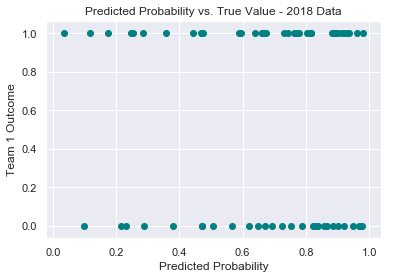

In [67]:
fig = plt.figure()
plt.scatter(svm_output['prob'],svm_output['True Value'],color="teal")
plt.title("Predicted Probability vs. True Value - 2018 Data")
plt.xlabel("Predicted Probability")
plt.ylabel("Team 1 Outcome")
fig.savefig('temp.png', transparent=True)
plt.show()

In [68]:
test_norm_2013_2017['team1_outcome'].head()

1045    0
1046    1
1047    0
1048    1
1049    0
Name: team1_outcome, dtype: int64

In [69]:
X_test['team2_seed'].head()

1045    0.666667
1046    1.000000
1047    0.666667
1048    1.000000
1049    0.400000
Name: team2_seed, dtype: float64

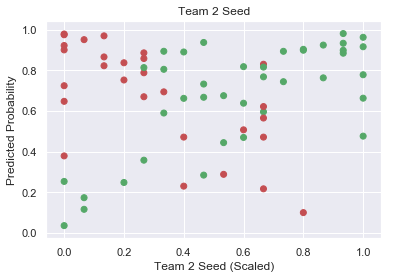

In [70]:
fig = plt.figure()

col = np.where(test_norm_2013_2017['team1_outcome'] == 1,'g','r')

plt.scatter(X_test['team2_seed'],svm_output['prob'],c=col)
plt.title("Team 2 Seed")
plt.xlabel("Team 2 Seed (Scaled)")
plt.ylabel("Predicted Probability")
fig.savefig('temp2.png', transparent=True)
plt.show()

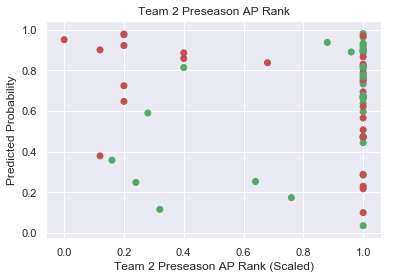

In [71]:
fig = plt.figure()

col = np.where(test_norm_2013_2017['team1_outcome'] == 1,'g','r')

plt.scatter(X_test['team2_ap_preseason'],svm_output['prob'],c=col)
plt.title("Team 2 Preseason AP Rank")
plt.xlabel("Team 2 Preseason AP Rank (Scaled)")
plt.ylabel("Predicted Probability")
fig.savefig('temp3.png', transparent=True)
plt.show()

In [72]:
data.iloc[1104]

team2_id                                                            1393
team2_score                                                           65
team1_id                                                            1181
team1_score                                                           69
WLoc                                                                   N
num_ot                                                                 0
team2_position                                                      X11b
team1_position                                                       X02
team2_seed                                                            11
team1_seed                                                             2
strongseed                                                             2
weakseed                                                              11
slot                                                                R3X2
team2_teamname                                     

In [73]:
hi = pd.concat([X_test['team2_num_top_players_mins'],svm_output['prob'],test_norm_2013_2017['team1_outcome']],axis=1)

hi[hi['team2_num_top_players_mins'] > 0]

,team2_num_top_players_mins,prob,team1_outcome
1047,1.000000,0.829559,0
1057,0.333333,0.969064,0
1091,1.000000,0.471351,0
1103,0.333333,0.900057,0
1104,1.000000,0.815519,1
1106,0.333333,0.379038,0
1108,0.333333,0.865442,0


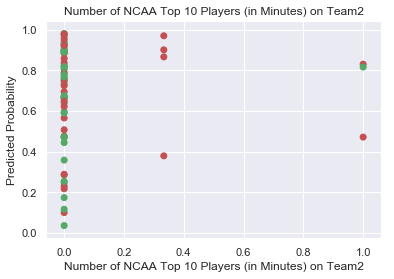

In [74]:
fig = plt.figure()

col = np.where(test_norm_2013_2017['team1_outcome'] == 1,'g','r')

plt.scatter(X_test['team2_num_top_players_mins'],svm_output['prob'],c=col)
plt.title("Number of NCAA Top 10 Players (in Minutes) on Team2")
plt.xlabel("Number of NCAA Top 10 Players (in Minutes) on Team2")
plt.ylabel("Predicted Probability")
fig.savefig('temp4.png', transparent=True)
plt.show()

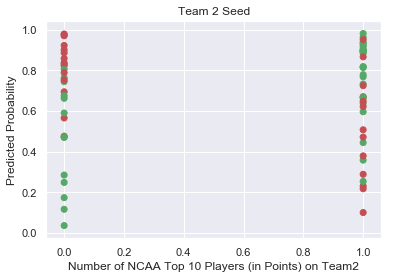

In [75]:
fig = plt.figure()

col = np.where(test_norm_2013_2017['team1_outcome'] == 1,'g','r')

plt.scatter(X_test['team1_lastyear_in'],svm_output['prob'],c=col)
plt.title("Team 2 Seed")
plt.xlabel("Number of NCAA Top 10 Players (in Points) on Team2")
plt.ylabel("Predicted Probability")
fig.savefig('temp5.png', transparent=True)
plt.show()

### Random Forest

In [76]:
rf_model = RandomForestClassifier(n_estimators=500, max_depth=3,random_state=1).fit(X_train_final,y_train)

In [77]:
#creating vector of predicted probabilities
y_test_rf_pred = []
y_test_rf_true = y_test.values

for i in range(0,len(X_test_final)):
    y_test_rf_pred.append(rf_model.predict_proba(X_test_final.iloc[i].values.reshape(1,-1))[0][1])
    
y_test_rf_pred = pd.DataFrame(y_test_rf_pred).set_index(y_test.index)
y_test_rf_true = pd.DataFrame(y_test_rf_true).set_index(y_test.index)

In [78]:
##Probability of a 1
rf_output = pd.concat([test_norm_2013_2017['game_id_new'],y_test_rf_true,y_test_rf_pred],axis=1)
rf_output.columns = ["game_id_new","True Value",'Predicted Probability of 1']
#rf_output[["game_id_new","Predicted Probability of 1"]].to_csv("Millennial Miners (Random Forest).csv",index=False)
rf_output

,game_id_new,True Value,Predicted Probability of 1
1045,2018-1417-1382,0,0.732532
1046,2018-1347-1254,1,0.551572
1047,2018-1113-1393,0,0.408228
1048,2018-1411-1300,1,0.640101
1049,2018-1328-1348,0,0.621974
1050,2018-1242-1335,1,0.846373
1051,2018-1211-1422,1,0.809319
1052,2018-1181-1233,1,0.863905
1053,2018-1460-1397,0,0.199587
1054,2018-1355-1326,0,0.307273


In [79]:
#Random Forest Accuracy
rf_accuracy = rf_model.score(X_test_final, y_test)
print("Random Forest Accuracy = ", rf_accuracy)

Random Forest Accuracy =  0.7164179104477612


In [80]:
#Random Forest Log Loss
rf_logloss = log_loss(y_test_rf_true,y_test_rf_pred)
print("Random Forest Log Loss = ", rf_logloss)

Random Forest Log Loss =  0.5489194707276854


### kNN

In [81]:
knn_model = KNeighborsClassifier(n_neighbors=10).fit(X_train_final,y_train)

In [82]:
#creating vector of predicted probabilities
y_test_knn_pred = []
y_test_knn_true = y_test.values

for i in range(0,len(X_test_final)):
    y_test_knn_pred.append(knn_model.predict_proba(X_test_final.iloc[i].values.reshape(1,-1))[0][1])
    
y_test_knn_pred = pd.DataFrame(y_test_knn_pred).set_index(y_test.index)
y_test_knn_true = pd.DataFrame(y_test_knn_true).set_index(y_test.index)

In [83]:
##Probability of a 1
knn_output = pd.concat([test_norm_2013_2017['game_id_new'],y_test_knn_true,y_test_knn_pred],axis=1)
knn_output.columns = ["game_id_new","True Value",'Predicted Probability of 1']
#rf_output[["game_id_new","Predicted Probability of 1"]].to_csv("Millennial Miners (Random Forest).csv",index=False)
knn_output

,game_id_new,True Value,Predicted Probability of 1
1045,2018-1417-1382,0,0.8
1046,2018-1347-1254,1,0.6
1047,2018-1113-1393,0,0.3
1048,2018-1411-1300,1,0.5
1049,2018-1328-1348,0,0.3
1050,2018-1242-1335,1,0.8
1051,2018-1211-1422,1,0.7
1052,2018-1181-1233,1,0.7
1053,2018-1460-1397,0,0.3
1054,2018-1355-1326,0,0.4


In [84]:
#kNN Forest Accuracy
knn_accuracy = knn_model.score(X_test_final, y_test)
print("kNN Accuracy = ", knn_accuracy)

kNN Accuracy =  0.6268656716417911


In [85]:
#Random Forest Log Loss
knn_logloss = log_loss(y_test_knn_true,y_test_knn_pred)
print("kNN Forest Log Loss = ", rf_logloss)

kNN Forest Log Loss =  0.5489194707276854


### Ensemble (Average & Majority Vote)

In [86]:
############ Ensemble using Average ############
##Aggregating all model predictions in one dataframe
df_game_id = pd.DataFrame(test_norm_2013_2017['game_id_new'])
df_y_true = pd.DataFrame(y_test).set_index(y_test.index)

all_model_predictions = pd.concat([df_game_id,df_y_true,y_test_log_pred,y_test_svm_pred,y_test_rf_pred],axis=1)
all_model_predictions.columns = ["game_id_new","True Value","Logistic Regression Prob","SVM Prob","Random Forest Prob"]
all_model_predictions['ensemble_avg_prob'] = all_model_predictions[["Logistic Regression Prob","SVM Prob","Random Forest Prob"]].mean(axis=1)
all_model_predictions

##Converting Ensemble (avg) probabilities to 1s and 0s to calculate accuracy
mask = all_model_predictions['ensemble_avg_prob'] >= .5
column_name = 'ensemble_avg_pred'
all_model_predictions.loc[mask, column_name] = 1

mask = all_model_predictions['ensemble_avg_prob'] < .5
column_name = 'ensemble_avg_pred'
all_model_predictions.loc[mask, column_name] = 0


#Calculating Ansemble (Avg) Accuracy
correct = 0

for i in range(0,len(all_model_predictions)):
    if all_model_predictions["True Value"].iloc[i] == all_model_predictions["ensemble_avg_pred"].iloc[i]:
        correct +=1


#Ensemble (avg) output 
ensemble_output = all_model_predictions[["game_id_new","ensemble_avg_prob"]]

    
print("Average Accuracy = ",correct/len(all_model_predictions))
print("Log Loss = ",log_loss(all_model_predictions["True Value"],all_model_predictions['ensemble_avg_prob']))

Average Accuracy =  0.746268656716418
Log Loss =  0.5392760642661198


In [87]:
############ Ensemble using Majority Vote ############

##Converting logist probabilities to 1s and 0s to calculate accuracy
mask = all_model_predictions['Logistic Regression Prob'] >= .5
column_name = 'logistic_regression_pred'
all_model_predictions.loc[mask, column_name] = 1

mask = all_model_predictions['Logistic Regression Prob'] < .5
column_name = 'logistic_regression_pred'
all_model_predictions.loc[mask, column_name] = 0

##Converting svm probabilities to 1s and 0s to calculate accuracy
mask = all_model_predictions['SVM Prob'] >= .5
column_name = 'svm_pred'
all_model_predictions.loc[mask, column_name] = 1

mask = all_model_predictions['SVM Prob'] < .5
column_name = 'svm_pred'
all_model_predictions.loc[mask, column_name] = 0

##Converting rf probabilities to 1s and 0s to calculate accuracy
mask = all_model_predictions['Random Forest Prob'] >= .5
column_name = 'rf_pred'
all_model_predictions.loc[mask, column_name] = 1

mask = all_model_predictions['Random Forest Prob'] < .5
column_name = 'rf_pred'
all_model_predictions.loc[mask, column_name] = 0

all_model_predictions["ensemble_majority_pred"] = np.nan

####### Creating the majority vote
for i in range(0,len(all_model_predictions)):
    if all_model_predictions["logistic_regression_pred"].iloc[i] + all_model_predictions["svm_pred"].iloc[i] + all_model_predictions["rf_pred"].iloc[i] >= 2:
        all_model_predictions["ensemble_majority_pred"].iloc[i] = 1
    else:
        all_model_predictions["ensemble_majority_pred"].iloc[i] = 0


####### Calculating majority vote accuracy
correct = 0

for i in range(0,len(all_model_predictions)):
    if all_model_predictions["True Value"].iloc[i] == all_model_predictions["ensemble_majority_pred"].iloc[i]:
        correct += 1

print("Majority Vote Accuracy = ",correct/len(all_model_predictions))

Majority Vote Accuracy =  0.7313432835820896


In [88]:
all_model_predictions

,game_id_new,True Value,Logistic Regression Prob,SVM Prob,Random Forest Prob,ensemble_avg_prob,ensemble_avg_pred,logistic_regression_pred,svm_pred,rf_pred,ensemble_majority_pred
1045,2018-1417-1382,0,0.544649,0.782738,0.732532,0.686640,1.0,1.0,1.0,1.0,1.0
1046,2018-1347-1254,1,0.382618,0.476175,0.551572,0.470122,0.0,0.0,0.0,1.0,0.0
1047,2018-1113-1393,0,0.255047,0.170441,0.408228,0.277905,0.0,0.0,0.0,0.0,0.0
1048,2018-1411-1300,1,0.449190,0.662719,0.640101,0.584003,1.0,0.0,1.0,1.0,1.0
1049,2018-1328-1348,0,0.423146,0.528561,0.621974,0.524560,1.0,0.0,1.0,1.0,1.0
1050,2018-1242-1335,1,0.784086,0.961912,0.846373,0.864124,1.0,1.0,1.0,1.0,1.0
1051,2018-1211-1422,1,0.666403,0.902810,0.809319,0.792844,1.0,1.0,1.0,1.0,1.0
1052,2018-1181-1233,1,0.829449,0.980352,0.863905,0.891235,1.0,1.0,1.0,1.0,1.0
1053,2018-1460-1397,0,0.240558,0.177906,0.199587,0.206017,0.0,0.0,0.0,0.0,0.0
1054,2018-1355-1326,0,0.305004,0.330262,0.307273,0.314180,0.0,0.0,0.0,0.0,0.0


## Testing on 2019 data

### Modifying 2019 like historical data

In [89]:
################################## READ IN DATA ##################################
data_2019 = pd.read_csv("NCAA_Tourney_2019.csv")


################################## DROP COACH NAME VARIABLES ##################################
data_2019 = data_2019.drop(["team1_coach_name","team2_coach_name"],axis=1)


################################## FILL NA ##################################
data_2019[["team1_ap_final","team1_ap_preseason","team1_coaches_before_final","team1_coaches_preseason","team2_ap_final","team2_ap_preseason","team2_coaches_before_final","team2_coaches_preseason"]] = data_2019[["team1_ap_final","team1_ap_preseason","team1_coaches_before_final","team1_coaches_preseason","team2_ap_final","team2_ap_preseason","team2_coaches_before_final","team2_coaches_preseason"]].fillna(26)
data_2019["host"] = data_2019["host"].fillna("dayton")
data_2019["host_lat"] = data_2019["host_lat"].fillna(39.76)
data_2019["host_long"] = data_2019["host_long"].fillna(-84.19)

################################## Converting team1_id and team2_id to object ##################################
#team1_id from int to string
data_2019['team1_id'] = data_2019['team1_id'].apply(str)

#team2_id from int to string
data_2019['team2_id'] = data_2019['team2_id'].apply(str)

################################## CLEANING REGIONS ##################################
data_2019['team1_region'] = data_2019['team1_region'].map({'W': 'East', 'Z': 'West','Y': 'South','X': 'Midwest'})
data_2019['team2_region'] = data_2019['team2_region'].map({'W': 'East', 'Z': 'West','Y': 'South','X': 'Midwest'})
#team1_region, team2_region
team1_region_dum = pd.get_dummies(data_2019['team1_region'],prefix="team1_region_")
team2_region_dum = pd.get_dummies(data_2019['team2_region'],prefix="team2_region_")


data_2019 = pd.concat([data_2019,team1_region_dum,team2_region_dum],axis=1)
data_2019 = data_2019.drop(["team1_region","team2_region"],axis=1)

################################## FEATURE: DISTANCE FROM HOST ##################################
from math import radians, cos, sin, asin, sqrt
def distance(lon1, lat1, lon2, lat2):

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

data_2019['team1_dist_from_host'] = [distance(data_2019.host_long[i],data_2019.host_lat[i],data_2019.team1_long[i],data_2019.team1_long[i]) for i in range(len(data_2019))]
data_2019['team2_dist_from_host'] = [distance(data_2019.host_long[i],data_2019.host_lat[i],data_2019.team2_long[i],data_2019.team2_long[i]) for i in range(len(data_2019))]



################################## FEATURE: CONFERENCE ##################################
conf = pd.read_csv("MDCM - School Conference.csv")

#Merge in all of team1's conferences
data_2019 = pd.merge(data_2019,conf,left_on=['team1_teamname'],right_on=['School'],how='left')

#drop School
data_2019 = data_2019.drop(['School'],axis=1)
data_2019 = data_2019.rename(columns={"Conference": "team1_conference","Public/Private":"team1_public/private"})

#Team2 conference

#Merge in all of team2's conferences
data_2019 = pd.merge(data_2019,conf,left_on=['team2_teamname'],right_on=['School'],how='left')
data_2019.head()

#drop School
data_2019 = data_2019.drop(['School'],axis=1)
data_2019 = data_2019.rename(columns={"Conference": "team2_conference","Public/Private":"team2_public/private"})

################################## FEATURE: CONFERENCE INFO ##################################

conf_info = pd.read_csv("MDCM - Conference Info.csv")
conf_info = conf_info.drop(['Conference Longevity'],axis=1)

#Merge in all of team1's conference info
data_2019 = pd.merge(data_2019,conf_info,left_on=['team1_conference'],right_on=['Conference'],how='left')
data_2019.head()

#drop Conference
data_2019 = data_2019.drop(['Conference'],axis=1)
data_2019 = data_2019.rename(columns={"Numnber of NCAA Champisonshps won": "team1_conference_champ_won","Final Four Appearances":"team1_conference_ff","NCAA Tournament appearances":"team1_conference_tourn"})

#Merge in all of team2's conference info
data_2019 = pd.merge(data_2019,conf_info,left_on=['team2_conference'],right_on=['Conference'],how='left')
data_2019.head()

#drop Conference
data_2019 = data_2019.drop(['Conference'],axis=1)
data_2019 = data_2019.rename(columns={"Numnber of NCAA Champisonshps won": "team2_conference_champ_won","Final Four Appearances":"team2_conference_ff","NCAA Tournament appearances":"team2_conference_tourn"})

################################## FEATURE: PLAYER INFO ##################################
player_info = pd.read_csv("MDCM - Top Player Stats by Season.csv")

#Team1 top Players
data_2019 = pd.merge(data_2019,player_info,left_on=['team1_teamname','season'],right_on=['School','Season'],how='left')

#drop School, season
data_2019 = data_2019.drop(['School','Season'],axis=1)
data_2019 = data_2019.rename(columns={"num top players mins": "team1_num_top_players_mins",
                            "num top players fg": "team1_num_top_players_fg",
                           "num top players blocks": "team1_num_top_players_blocks",
                           "num top players points": "team1_num_top_players_points"})

#Team2 top Players
#Merge in all of team2's conferences
data_2019 = pd.merge(data_2019,player_info,left_on=['team2_teamname','season'],right_on=['School','Season'],how='left')

#drop School, season
data_2019 = data_2019.drop(['School','Season'],axis=1)
data_2019 = data_2019.rename(columns={"num top players mins": "team2_num_top_players_mins",
                            "num top players fg": "team2_num_top_players_fg",
                           "num top players blocks": "team2_num_top_players_blocks",
                           "num top players points": "team2_num_top_players_points"})

################################## FEATURE: OVERALL SCHOOL STATS ##################################
school_stats = pd.read_csv("MDCM - School Stats.csv")

#Merge in all of team1's school stats
data_2019 = pd.merge(data_2019,school_stats,left_on=['team1_teamname'],right_on=['School'],how='left')

#drop School
data_2019 = data_2019.drop(['School'],axis=1)
data_2019 = data_2019.rename(columns={"Yrs": "team1_yrs",
                           "G": "team1_G",
                           "W": "team1_W",
                           "L": "team1_L",
                           "W-L%": "team1_W-L%",
                           "SRS": "team1_SRS",
                           "SOS": "team1_SOS",
                           "AP": "team1_AP",
                           "CREG": "team1_CREG",
                           "CTRN": "team1_CTRN",
                           "NCAA": "team1_NCAA",
                           "FF": "team1_FF",
                           "NC": "team1_NC"})

#Merge in all of team2's school stats
data_2019 = pd.merge(data_2019,school_stats,left_on=['team2_teamname'],right_on=['School'],how='left')
data_2019.head()

#drop School
data_2019 = data_2019.drop(['School'],axis=1)
data_2019 = data_2019.rename(columns={"Yrs": "team2_yrs",
                           "G": "team2_G",
                           "W": "team2_W",
                           "L": "team2_L",
                           "W-L%": "team2_W-L%",
                           "SRS": "team2_SRS",
                           "SOS": "team2_SOS",
                           "AP": "team2_AP",
                           "CREG": "team1_CREG",
                           "CTRN": "team2_CTRN",
                           "NCAA": "team2_NCAA",
                           "FF": "team2_FF",
                           "NC": "team2_NC"})

################################## FEATURE: MADE FINAL ROUND LAST YEAR ##################################
##New Variable
##If team 1 enter the final round(Being recoreded in our dataset), the value is 1. Otherwise the value is 0
##All based on historical data, so all values for 2002 season is 0, which cannot be used. All value after 2002 can be used for training.
team1_lastyear_in=[]
team2_lastyear_in=[]

for i in range(len(data_2019)):
    if (data_2019['season'][i]==2002):
        team1_lastyear_in.append(0)
        team2_lastyear_in.append(0)
    else:
        lastyear=data_2019['season'][i]-1
        if((data_2019['team1_id'][i] in data_2019[data_2019['season']==lastyear]['team2_id'].tolist()) or (data_2019['team1_id'][i] in data_2019[data_2019['season']==lastyear]['team1_id'].tolist())):
            team1_lastyear_in.append(1)
        else:
            team1_lastyear_in.append(0)
            
        if((data_2019['team2_id'][i] in data_2019[data_2019['season']==lastyear]['team1_id'].tolist()) or (data_2019['team2_id'][i] in data_2019[data_2019['season']==lastyear]['team2_id'].tolist())):
            team2_lastyear_in.append(1)
        else:
            team2_lastyear_in.append(0)

##Add these 2 Variables(team1_lastyear_in and team2_lastyear_in)
data_2019['team1_lastyear_in']=team1_lastyear_in
data_2019['team2_lastyear_in']=team2_lastyear_in


################################## FEATURE: MADE FINAL ROUND IN THE LAST 3 YEARS ##################################

##New Variable
##Continually Enter final round in last 3 years. If True, the value is 1, otherwise the value is 0.
##All based on historical data, so all values for 2002-2004 season is 0, which cannot be used. All value after 2004 can be used.
team1_3year_in=[]
team2_3year_in=[]

for i in range(len(data_2019)):
    if (data_2019['season'][i]<2005):
        team1_3year_in.append(0)
        team2_3year_in.append(0)
    else:
        oneyear=data_2019['season'][i]-1
        twoyear=data_2019['season'][i]-2
        threeyear=data_2019['season'][i]-3
        if(((data_2019['team1_id'][i] in data_2019[data_2019['season']==oneyear]['team2_id'].tolist()) or (data_2019['team1_id'][i] in data_2019[data_2019['season']==oneyear]['team1_id'].tolist()))\
          and ((data_2019['team1_id'][i] in data_2019[data_2019['season']==twoyear]['team2_id'].tolist()) or (data_2019['team1_id'][i] in data_2019[data_2019['season']==twoyear]['team1_id'].tolist()))\
          and ((data_2019['team1_id'][i] in data_2019[data_2019['season']==threeyear]['team2_id'].tolist()) or (data_2019['team1_id'][i] in data_2019[data_2019['season']==threeyear]['team1_id'].tolist()))):
            team1_3year_in.append(1)
        else:
            team1_3year_in.append(0)
            
        if(((data_2019['team2_id'][i] in data_2019[data_2019['season']==oneyear]['team2_id'].tolist()) or (data_2019['team2_id'][i] in data_2019[data_2019['season']==oneyear]['team1_id'].tolist()))\
          and ((data_2019['team2_id'][i] in data_2019[data_2019['season']==twoyear]['team2_id'].tolist()) or (data_2019['team2_id'][i] in data_2019[data_2019['season']==twoyear]['team1_id'].tolist()))\
          and ((data_2019['team2_id'][i] in data_2019[data_2019['season']==threeyear]['team2_id'].tolist()) or (data_2019['team2_id'][i] in data_2019[data_2019['season']==threeyear]['team1_id'].tolist()))):
            team2_3year_in.append(1)
        else:
            team2_3year_in.append(0)
            
##Add these 2 Variables (team1_3year_in and team2_3year_in)
data_2019['team1_3year_in']=team1_3year_in
data_2019['team2_3year_in']=team2_3year_in


################################## Converting conference variables to dummies ##################################
#team1_conference, team2_conference
team1_conference_dum = pd.get_dummies(data_2019['team1_conference'],prefix="team1_conference")
team2_conference_dum = pd.get_dummies(data_2019['team2_conference'],prefix="team2_conference")


data_2019 = pd.concat([data_2019,team1_conference_dum,team2_conference_dum],axis=1)
data_2019 = data_2019.drop(["team1_conference","team2_conference"],axis=1)
data_2019.head()


################################## Converting Public/Private variables to dummies ##################################

#team1_conference, team2_conference
team1_pubpriv_dum = pd.get_dummies(data_2019["team1_public/private"],prefix="team1_public/private")
team2_pubpriv_dum = pd.get_dummies(data_2019['team2_public/private'],prefix="team2_public/private")


data_2019 = pd.concat([data_2019,team1_pubpriv_dum,team2_pubpriv_dum],axis=1)
data_2019 = data_2019.drop(["team1_public/private","team2_public/private"],axis=1)

data_2019.head()
################################## NORMALIZING ##################################
##Normalize only quantitative features
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_2019.drop(['game_id', 'host', 'slot', 'team1_coach_id', 'team1_id','team1_position', 'team1_teamname', 'team2_coach_id', 'team2_id','team2_position', 'team2_teamname','season'],axis=1))

data_norm = pd.DataFrame(np_scaled,columns = data_2019.drop(['game_id', 'host', 'slot', 'team1_coach_id', 'team1_id','team1_position', 'team1_teamname', 'team2_coach_id', 'team2_id','team2_position', 'team2_teamname','season'],axis=1).columns)
data_norm.head()

#Left over categorical variables and target variable that will be used for the model
data_2019[['slot','team1_position','team2_position','season','game_id']].head()

#Dataset with normalized quantitative features and original categorical features
data_norm_full_2019 = pd.concat((data_norm,data_2019[['slot','team1_position','team2_position','season','game_id','team1_teamname','team2_teamname','team1_coach_id','team2_coach_id']]),axis=1)
data_norm_full_2019.shape

(2278, 216)

### Creating new Train Set

### Gathering most recent 5 years of historical data (2014 - 2018)

In [90]:
####Using most recent 5 years with normalization

train_norm_2014_2018 = data_norm_full[(data_norm_full['season'] == [2018]) 
                                | (data_norm_full['season'] == [2017]) 
                                | (data_norm_full['season'] == [2016])
                                | (data_norm_full['season'] == [2015])
                                | (data_norm_full['season'] == [2014])]
test_norm_2014_2018 = data_norm_full[(data_norm_full['season'] == 2019)]

### Splitting into test/train sets

In [91]:
################ SCENARIO 4 #################
X_train = train_norm_2014_2018.drop(['team1_score','team2_score','game_id',  'slot', 'team1_position','team2_position', 'team1_outcome','season','team1_teamname','team2_teamname','team1_coach_id','team2_coach_id','game_id_new'],axis=1)
y_train = train_norm_2014_2018["team1_outcome"]

In [92]:
lasso = LassoCV(cv=10)

sfm = SelectFromModel(lasso)

sfm = sfm.fit(X_train, y_train)
X_train_transform = sfm.transform(X_train)

X_train_final_2019 = X_train[X_train.columns[sfm.get_support()]]
print("Number of features with Lasso and CV: ", X_train_final_2019.shape[1])
print("LassoCV selected features:", X_train_final_2019.columns)

features_lasso = list(X_train.columns[sfm.get_support()])
print("lasso feature list",features_lasso)

X_test_final_2019 = data_norm_full_2019[features_lasso]

print("final test set dimensions",X_test_final_2019.shape)

X_test_final_2019.head()

Number of features with Lasso and CV:  25
LassoCV selected features: Index(['team2_seed', 'host_long', 'team2_lat',
       'team1_pt_career_overall_losses', 'team2_coaches_before_final',
       'team1_ap_final', 'team1_coaches_before_final',
       'team1_coaches_preseason', 'team2_adjde', 'team1_region__Midwest',
       'team2_region__West', 'team1_conference_champ_won',
       'team2_conference_ff', 'team2_conference_tourn',
       'team1_num_top_players_mins', 'team1_num_top_players_fg',
       'team1_num_top_players_points', 'team2_num_top_players_mins',
       'team2_num_top_players_points', 'team1_lastyear_in', 'team1_3year_in',
       'team2_3year_in', 'team1_conference_Southeastern',
       'team2_conference_Atlantic Coast', 'team2_conference_Big 12'],
      dtype='object')
lasso feature list ['team2_seed', 'host_long', 'team2_lat', 'team1_pt_career_overall_losses', 'team2_coaches_before_final', 'team1_ap_final', 'team1_coaches_before_final', 'team1_coaches_preseason', 'team2_a

,team2_seed,host_long,team2_lat,team1_pt_career_overall_losses,team2_coaches_before_final,team1_ap_final,team1_coaches_before_final,team1_coaches_preseason,team2_adjde,team1_region__Midwest,team2_region__West,team1_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_points,team1_lastyear_in,team1_3year_in,team2_3year_in,team1_conference_Southeastern,team2_conference_Atlantic Coast,team2_conference_Big 12
0,0.066667,0.221023,0.740737,0.796526,0.24,0.16,0.16,0.08,0.184705,0.0,0.0,0.933333,1.000000,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.133333,0.221023,0.095124,0.796526,0.32,0.16,0.16,0.08,0.472316,0.0,0.0,0.933333,0.607843,0.836735,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.200000,0.221023,0.452949,0.796526,0.56,0.16,0.16,0.08,0.327943,0.0,0.0,0.933333,0.882353,0.910204,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.266667,0.221023,0.252998,0.796526,1.00,0.16,0.16,0.08,0.440155,0.0,0.0,0.933333,0.607843,0.836735,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.333333,0.221023,0.544789,0.796526,0.80,0.16,0.16,0.08,0.323152,0.0,0.0,0.933333,1.000000,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
lasso_coefs = lasso.fit(X_train, y_train).coef_

In [94]:
lasso_coefs[lasso_coefs > 0]

array([0.17154835, 0.00532393, 0.05618477, 0.46769103, 0.12295339,
       0.10208155, 0.04341836, 0.07548445, 0.0996592 , 0.00329696,
       0.00881218, 0.05953425, 0.02307946, 0.04171292, 0.00783908])

In [95]:
lasso_coefs

array([ 0.        ,  0.17154835,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.00532393, -0.02387411, -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.05618477,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.46769103,  0.        ,  0.12295339, -0.        ,
       -0.59015446, -0.01104581, -0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.  

In [96]:
X_train.iloc[:,45]

777     1.00
778     1.00
779     1.00
780     0.88
781     1.00
782     0.72
783     1.00
784     1.00
785     1.00
786     1.00
787     0.28
788     1.00
789     1.00
790     1.00
791     1.00
792     0.96
793     0.64
794     1.00
795     1.00
796     0.12
797     1.00
798     1.00
799     1.00
800     1.00
801     1.00
802     0.52
803     1.00
804     1.00
805     0.60
806     0.80
807     1.00
808     0.92
809     1.00
810     0.56
811     0.36
812     0.24
813     0.48
814     0.64
815     0.08
816     0.96
817     1.00
818     1.00
819     1.00
820     1.00
821     0.16
822     0.68
823     0.80
824     0.24
825     0.92
826     1.00
827     1.00
828     1.00
829     0.16
830     0.72
831     0.08
832     0.12
833     0.40
834     0.04
835     0.88
836     0.36
837     0.72
838     0.16
839     0.28
840     0.04
841     0.08
842     0.12
843     0.00
844     1.00
845     1.00
846     1.00
847     1.00
848     1.00
849     0.76
850     0.88
851     1.00
852     1.00
853     1.00

### Training Models on last five years of data (2014 - 2018)

In [97]:
###Classification Models

log_model = LogisticRegressionCV(cv=10, random_state=1,multi_class='multinomial').fit(X_train_final_2019, y_train)

svm_model = SVC(kernel="linear",probability=True,C=1).fit(X_train_final_2019,y_train)

rf_model = RandomForestClassifier(n_estimators=500, max_depth=3,random_state=1).fit(X_train_final_2019,y_train)

## Predictions with Lasso Features (25)

In [98]:
################################## SVM ##################################
pred_2019_svm = []

for i in range(0,len(X_test_final_2019)):
    pred_2019_svm.append(svm_model.predict_proba(X_test_final_2019.iloc[i].values.reshape(1,-1))[0][1])

pred_2019_svm = pd.DataFrame(pred_2019_svm).set_index(data_norm_full_2019.index)

svm_output_2019 = pd.concat([data_norm_full_2019['game_id'],data_norm_full_2019['team1_teamname'],data_norm_full_2019['team2_teamname'],pred_2019_svm],axis=1)
svm_output_2019.columns = ["game_id","team1","team2",'Probability of 1']  ###Making the col n
svm_output_2019.to_csv("2019_predictions_lasso_svm.csv")

################################## LOGISTIC REGRESSION ##################################
pred_2019_logreg = []

for i in range(0,len(X_test_final_2019)):
    pred_2019_logreg.append(log_model.predict_proba(X_test_final_2019.iloc[i].values.reshape(1,-1))[0][1])

pred_2019_logreg = pd.DataFrame(pred_2019_logreg).set_index(data_norm_full_2019.index)

log_output_2019 = pd.concat([data_norm_full_2019['game_id'],data_norm_full_2019['team1_teamname'],data_norm_full_2019['team2_teamname'],pred_2019_logreg],axis=1)
log_output_2019.columns = ["game_id","team1","team2",'Probability of 1']
log_output_2019.to_csv("2019_predictions_lasso_LogReg.csv")

################################## RANDOM FOREST ##################################
pred_2019_ranfor = []

for i in range(0,len(X_test_final_2019)):
    pred_2019_ranfor.append(rf_model.predict_proba(X_test_final_2019.iloc[i].values.reshape(1,-1))[0][1])
    
pred_2019_ranfor = pd.DataFrame(pred_2019_ranfor).set_index(data_norm_full_2019.index)

rf_output_2019 = pd.concat([data_norm_full_2019['game_id'],data_norm_full_2019['team1_teamname'],data_norm_full_2019['team2_teamname'],pred_2019_ranfor],axis=1)
rf_output_2019.columns = ["game_id","team1","team2",'Probability of 1']
rf_output_2019.to_csv("2019_predictions_lasso_RanFor.csv",index=False)

################################## Ensemble Average ##################################
df_game_id = pd.DataFrame(data_norm_full_2019['game_id'])

all_model_predictions = pd.concat([data_norm_full_2019['game_id'],data_norm_full_2019['team1_teamname'],data_norm_full_2019['team2_teamname'],svm_output_2019['Probability of 1'],log_output_2019['Probability of 1'],rf_output_2019['Probability of 1']],axis=1)
all_model_predictions.columns = ["game_id","team1","team2","SVM Prob","Logistic Regression Prob","Random Forest Prob"]
all_model_predictions['ensemble_avg_prob'] = all_model_predictions[["Logistic Regression Prob","SVM Prob","Random Forest Prob"]].mean(axis=1)

pred_2019_ens = all_model_predictions['ensemble_avg_prob']
pred_2019_ens.to_csv("2019_predictions_lasso_ensemble.csv")

all_model_predictions.to_csv('all_model_predictions.csv')


In [100]:
#outcome = pd.read_csv("march_madness_pred_and_outcome_3.28.csv")

In [101]:
# new = pd.merge(svm_output_2019,outcome,on=["game_id"],how='right')
# new = new.drop(["team1_x","team2_x","Probability of 1","index"],axis=1)
# new.columns = ("game_id","team1","team2","SVM prob","team1_outcome")

In [117]:
data_2019_no_norm = pd.concat([data_2019[features_lasso],data_2019["game_id"]],axis=1)

In [103]:
# new2 = pd.merge(new,data_2019_no_norm,on="game_id",how="left")

In [105]:
# new2[new2["game_id"] == "2019-1276-1403"]

In [106]:
# fig = plt.figure()
# plt.scatter(new2['SVM prob'],new2['team1_outcome'],color="teal")
# plt.title("Predicted Probability vs. True Value - 2019 Data")
# plt.xlabel("Predicted Probability")
# plt.ylabel("Team 1 Outcome")
# plt.show()

In [119]:
data_2019_no_norm = pd.concat([data_2019_no_norm,data_2019["team1_teamname"]],axis=1)

In [120]:
data_2019_no_norm = pd.concat([data_2019_no_norm,data_2019["team2_teamname"]],axis=1)

In [124]:
data_2019_no_norm[(data_2019_no_norm["team1_teamname"] == "Gonzaga") & (data_2019_no_norm["team2_teamname"] == "Texas Tech")]

,team2_seed,host_long,team2_lat,team1_pt_career_overall_losses,team2_coaches_before_final,team1_ap_final,team1_coaches_before_final,team1_coaches_preseason,team2_adjde,team1_region__Midwest,team2_region__West,team1_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_points,team1_lastyear_in,team1_3year_in,team2_3year_in,team1_conference_Southeastern,team2_conference_Atlantic Coast,team2_conference_Big 12,game_id,team1_teamname,team2_teamname
1054,3,-117.89,33.580309,120,6.0,1.0,1.0,4.0,86.0594,1,0,2,1,125,0,0,0,0,0,0,0,0,0,0,1,2019-1211-1403,Gonzaga,Texas Tech


In [136]:
data_2019_no_norm[(data_2019_no_norm["team1_teamname"] == "Michigan") & (data_2019_no_norm["team2_teamname"] == "Texas Tech")]

,team2_seed,host_long,team2_lat,team1_pt_career_overall_losses,team2_coaches_before_final,team1_ap_final,team1_coaches_before_final,team1_coaches_preseason,team2_adjde,team1_region__Midwest,team2_region__West,team1_conference_champ_won,team2_conference_ff,team2_conference_tourn,team1_num_top_players_mins,team1_num_top_players_fg,team1_num_top_players_points,team2_num_top_players_mins,team2_num_top_players_points,team1_lastyear_in,team1_3year_in,team2_3year_in,team1_conference_Southeastern,team2_conference_Atlantic Coast,team2_conference_Big 12,game_id,team1_teamname,team2_teamname
1102,3,-117.89,33.580309,322,6.0,10.0,11.0,18.0,86.0594,1,0,10,1,125,0,0,0,0,0,0,0,0,0,0,1,2019-1276-1403,Michigan,Texas Tech


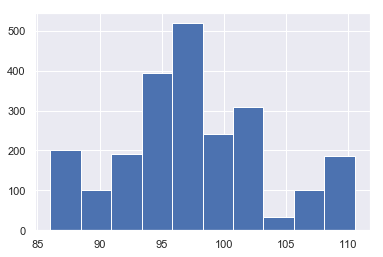

In [135]:
plt.hist(data_2019_no_norm["team2_adjde"])
plt.show()

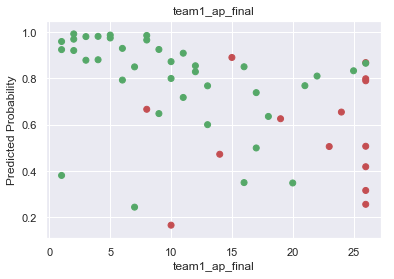

In [246]:
fig = plt.figure()

col = np.where(new2['team1_outcome'] == 1,'g','r')

plt.scatter(new2['team1_ap_final'],new2['SVM prob'],c=col) #change this
plt.title("team1_ap_final")    #change this
plt.xlabel("team1_ap_final")   #change this
plt.ylabel("Predicted Probability")
plt.show()